In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from IPython.display import display, HTML
from io import BytesIO
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv
/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv


In [79]:
# Importing Libraries

import warnings
warnings.filterwarnings("ignore")

import optuna
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import catboost as cb
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

In [80]:
# Reading .csv data file
train_data = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
original_data = pd.read_csv('/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv')

# original_data: 강우량 예측 모델을 학습하는 데 사용되는 원본 데이터 

In [81]:
train_data.sample(5)

id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
105    105  106    1008.9     28.0         27.8     25.2      25.2      89.0   
1181  1181   87    1012.1     27.9         25.8     24.1      23.3      89.0   
1822  1822  363    1012.6     20.5         19.2     18.4      17.9      93.0   
65      65   66    1022.7     14.3         12.8     10.0       8.0      63.0   
654    654  290    1013.4     29.1         23.5     21.0      19.9      82.0   

      cloud  sunshine  winddirection  windspeed  rainfall  
105    88.0       0.4           70.0       34.2         1  
1181   84.0       2.1           80.0       14.2         1  
1822   93.0       0.0           30.0       31.9         1  
65     95.0       0.1           20.0       24.5         1  
654    74.0       6.4           30.0       25.1         1

In [82]:
test_data.sample(5)

id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
2    2192    3    1023.9     11.2         10.4      9.4       8.9      86.0   
447  2637   83    1011.0     25.6         23.0     21.3      19.6      87.0   
383  2573   19    1020.6     19.3         16.6     13.7       3.1      48.0   
483  2673  119    1012.2     27.5         25.9     24.5      22.0      82.0   
573  2763  209    1008.0     33.0         30.7     27.9      25.4      73.0   

     cloud  sunshine  winddirection  windspeed  
2     96.0       0.0           40.0       16.9  
447   90.0       0.2           70.0       11.7  
383   22.0       9.8           30.0       26.2  
483   85.0       2.2           80.0       38.0  
573   29.0      11.4          170.0       26.2

In [83]:
original_data.sample(5)

day  pressure   maxtemp  temparature  mintemp  dewpoint  humidity   \
43    13     1012.5     25.9         23.1     21.3      21.1         89   
86    27     1024.1     22.4         17.3     14.6       8.4         58   
70    11     1022.6     14.3         11.9     10.0       8.0         77   
174   23     1008.4     34.1         30.4     28.4      24.7         72   
143   23     1008.4     28.9         26.8     24.8      23.2         81   

     cloud  rainfall  sunshine           winddirection  windspeed  
43       76       no       3.5                   200.0       10.2  
86       19       no      11.1                    30.0       14.6  
70       93      yes       0.0                    20.0       25.0  
174      20       no      11.4                   210.0        9.6  
143      65      yes       6.4                    20.0        7.9

In [84]:
original_data.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

> 📚Some feature names in the dataset, such as 'pressure', 'humidity', and 'winddirection', contain unwanted spaces at the beginning or end. So these spaces need to be removed to avoid issues during data processing and model training.

In [85]:
# Removing spaces at the start and end of column names
original_data.columns = original_data.columns.str.strip()

In [86]:
original_data.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [87]:
# Converting 'rainfall' column to binary format
original_data['rainfall'] = original_data['rainfall'].map({'yes': 1, 'no': 0})

In [88]:
# Checking the number of rows and columns

num_train_rows, num_train_columns = train_data.shape

num_test_rows, num_test_columns = test_data.shape

num_original_rows, num_original_columns = original_data.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Original Data:")
print(f"Number of Rows: {num_original_rows}")
print(f"Number of Columns: {num_original_columns}")

Training Data:
Number of Rows: 2190
Number of Columns: 13

Test Data:
Number of Rows: 730
Number of Columns: 12

Original Data:
Number of Rows: 366
Number of Columns: 12


In [89]:
# Creating a table for missing values, unique values and data types of the features

missing_values_train = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] No. of Missing Values': train_data.isnull().sum().values,
                              '[TRAIN] % of Missing Values': ((train_data.isnull().sum().values)/len(train_data)*100)})

missing_values_test = pd.DataFrame({'Feature': test_data.columns,
                             '[TEST] No.of Missing Values': test_data.isnull().sum().values,
                             '[TEST] % of Missing Values': ((test_data.isnull().sum().values)/len(test_data)*100)})

missing_values_original = pd.DataFrame({'Feature': original_data.columns,
                             '[ORIGINAL] No.of Missing Values': original_data.isnull().sum().values,
                             '[ORIGINAL] % of Missing Values': ((original_data.isnull().sum().values)/len(original_data)*100)})

unique_values = pd.DataFrame({'Feature': train_data.columns,
                              'No. of Unique Values[FROM TRAIN]': train_data.nunique().values})

feature_types = pd.DataFrame({'Feature': train_data.columns,
                              'DataType': train_data.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, missing_values_original, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

Feature  [TRAIN] No. of Missing Values  [TRAIN] % of Missing Values  \
0              id                              0                          0.0   
1             day                              0                          0.0   
2        pressure                              0                          0.0   
3         maxtemp                              0                          0.0   
4     temparature                              0                          0.0   
5         mintemp                              0                          0.0   
6        dewpoint                              0                          0.0   
7        humidity                              0                          0.0   
8           cloud                              0                          0.0   
9        sunshine                              0                          0.0   
10  winddirection                              0                          0.0   
11      windspeed                              0                          0.0   
12       rainfall                              0                          0.0   

    [TEST] No.of Missing Values  [TEST] % of Missing Values  \
0                           0.0                    0.000000   
1                           0.0                    0.000000   
2                           0.0                    0.000000   
3                           0.0                    0.000000   
4                           0.0                    0.000000   
5                           0.0                    0.000000   
6                           0.0                    0.000000   
7                           0.0                    0.000000   
8                           0.0                    0.000000   
9                           0.0                    0.000000   
10                          1.0                    0.136986   
11                          0.0                    0.000000   
12                          NaN                         NaN   

    [ORIGINAL] No.of Missing Values  [ORIGINAL] % of Missing Values  \
0                               NaN                             NaN   
1                               0.0                        0.000000   
2                               0.0                        0.000000   
3                               0.0                        0.000000   
4                               0.0                        0.000000   
5                               0.0                        0.000000   
6                               0.0                        0.000000   
7                               0.0                        0.000000   
8                               0.0                        0.000000   
9                               0.0                        0.000000   
10                              1.0                        0.273224   
11                              1.0                        0.273224   
12                              0.0                        0.000000   

    No. of Unique Values[FROM TRAIN] DataType  
0                               2190    int64  
1                                365    int64  
2                                236  float64  
3                                219  float64  
4                                198  float64  
5                                199  float64  
6                                218  float64  
7                                 49  float64  
8                                 78  float64  
9                                120  float64  
10                                35  float64  
11                               223  float64  
12                                 2    int64

In [90]:
# 데이터셋에서 중복 데이터를 탐지

# Count duplicate rows in train_data
train_duplicates = train_data.duplicated().sum()

# Count duplicate rows in test_data
test_duplicates = test_data.duplicated().sum()

# Count duplicate rows in original_data
original_duplicates = original_data.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in original_data: {original_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in original_data: 0


In [91]:
# Having a look at the description of all the numerical columns present in the dataset

train_data.describe().T

count         mean         std    min       25%      50%  \
id             2190.0  1094.500000  632.342866    0.0   547.250  1094.50   
day            2190.0   179.948402  105.203592    1.0    89.000   178.50   
pressure       2190.0  1013.602146    5.655366  999.0  1008.600  1013.00   
maxtemp        2190.0    26.365799    5.654330   10.4    21.300    27.80   
temparature    2190.0    23.953059    5.222410    7.4    19.300    25.50   
mintemp        2190.0    22.170091    5.059120    4.0    17.700    23.85   
dewpoint       2190.0    20.454566    5.288406   -0.3    16.800    22.15   
humidity       2190.0    82.036530    7.800654   39.0    77.000    82.00   
cloud          2190.0    75.721918   18.026498    2.0    69.000    83.00   
sunshine       2190.0     3.744429    3.626327    0.0     0.400     2.40   
winddirection  2190.0   104.863151   80.002416   10.0    40.000    70.00   
windspeed      2190.0    21.804703    9.898659    4.4    14.125    20.50   
rainfall       2190.0     0.753425    0.431116    0.0     1.000     1.00   

                    75%     max  
id             1641.750  2189.0  
day             270.000   365.0  
pressure       1017.775  1034.6  
maxtemp          31.200    36.0  
temparature      28.400    31.5  
mintemp          26.400    29.8  
dewpoint         25.000    26.7  
humidity         88.000    98.0  
cloud            88.000   100.0  
sunshine          6.800    12.1  
winddirection   200.000   300.0  
windspeed        27.900    59.5  
rainfall          1.000     1.0

<div style="background-color: #E8F8F5; border-left: 8px solid #1ABC9C; padding: 20px; border-radius: 8px; font-size: 14px; color: #000000;">
  <h3 style="font-size: 20px; margin-bottom: 10px;">📊 <strong>Dataset Observations</strong></h3>
  <hr>

  <p><strong>1️⃣ Dataset Shape 📂</strong></p>
  <ul>
    <li><strong>Training Data:</strong> <strong>2,190 rows × 13 columns</strong>.</li>
    <li><strong>Test Data:</strong> <strong>730 rows × 12 columns</strong>.</li>
    <li><strong>Original Data:</strong> <strong>366 rows × 12 columns</strong>.</li>
  </ul>
  <hr>

  <p><strong>2️⃣ Missing Values Analysis ❌</strong></p>
  <ul>
    <li><strong>No missing values</strong> in the training dataset.</li>
    <li>The <code>winddirection</code> feature contains <strong>one missing value</strong> in the test dataset.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Use <strong>mean or median imputation</strong> to handle missing values efficiently.</p>
  <hr>

  <p><strong>3️⃣ Key Observations on Data 🧐</strong></p>
  <ul>
    <li><strong>ID:</strong> A unique identifier for each record.</li>
    <li><strong>Day:</strong> Represents the <strong>day of the year (1 to 365)</strong>.</li>
    <li><strong>Pressure:</strong> Ranges from <strong>999 to 1034.6 hPa</strong>. 대기의 압력을 나타내는 데이터로, 기압이 낮아지면 저기압이 형성되어 상승 기류가 발생하고, 이는 구름 형성과 강우로 이어질 수 있음</li>
    <li><strong>Temperature Features:</strong> Max temp (<strong>10.4°C - 36.0°C</strong>), Min temp (<strong>4.0°C - 29.8°C</strong>), and Average temp.</li>
    <li><strong>Dew Point:</strong> Ranges from <strong>-0.3°C to 26.7°C</strong>. 공기 중 수중기가 응결되어 액체 상태의 물방울(이슬)로 변하기 시작하는 온도를 의미</li>
    <li><strong>Humidity:</strong> Ranges from <strong>39% to 98%</strong>.</li>
    <li><strong>Cloud Cover:</strong> Ranges from <strong>2% to 100%</strong>. 아마 낮은 %일수록 하늘에 구름이 전혀 없는 맑은 상태를 의미하고, 100%는 하늘 전체가 구름으로 뒤덮인 흐린 상태를 의미(?)</li>
    <li><strong>Sunshine Duration:</strong> Ranges from <strong>0 to 12.1 hours</strong>. 하루 동안 햇빛이 지표면에 도달한 시간으로 즉, 맑은 날씨의 지속 시간을 나타내는 지표</li>
    <li><strong>Wind Speed:</strong> Ranges from <strong>4.4 km/h to 59.5 km/h</strong>.</li>
    <li><strong>Wind Direction:</strong> Categorical, with <strong>35 unique values</strong>.</li>
    <li><strong>Rainfall:</strong> Binary target variable (<strong>0 = No Rain, 1 = Rain</strong>).</li>
  </ul>
  <hr>

  <p><strong>4️⃣ Summary Statistics 📊</strong></p>
  <ul>
    <li><strong>Pressure:</strong> Mean: <strong>1013.6 hPa</strong>, Min: <strong>999.0</strong>, Max: <strong>1034.6</strong>.</li>
    <li><strong>Max Temperature:</strong> Mean: <strong>26.36°C</strong>, Min: <strong>10.4°C</strong>, Max: <strong>36.0°C</strong>.</li>
    <li><strong>Min Temperature:</strong> Mean: <strong>22.17°C</strong>, Min: <strong>4.0°C</strong>, Max: <strong>29.8°C</strong>.</li>
    <li><strong>Dew Point:</strong> Mean: <strong>20.45°C</strong>, Min: <strong>-0.3°C</strong>, Max: <strong>26.7°C</strong>.</li>
    <li><strong>Humidity:</strong> Mean: <strong>82.03%</strong>, Min: <strong>39%</strong>, Max: <strong>98%</strong>.</li>
    <li><strong>Cloud Cover:</strong> Mean: <strong>75.72%</strong>, Min: <strong>2%</strong>, Max: <strong>100%</strong>.</li>
    <li><strong>Sunshine:</strong> Mean: <strong>3.74 hours</strong>, Min: <strong>0 hours</strong>, Max: <strong>12.1 hours</strong>.</li>
    <li><strong>Wind Speed:</strong> Mean: <strong>21.8 km/h</strong>, Min: <strong>4.4 km/h</strong>, Max: <strong>59.5 km/h</strong>.</li>
    <li><strong>Rainfall:</strong> Mean: <strong>0.75</strong>, indicating <strong>~75% rainy days</strong> in the dataset.</li>
  </ul>
  <hr>

  <p><strong>5️⃣ Key Takeaways 🔍</strong></p>
  <ul>
    <li>The dataset consists of <strong>numerical weather variables</strong>, requiring appropriate <strong>scaling</strong>.</li>
    <li><code>winddirection</code> can potentially be <strong>categorical</strong> as it has a limited number of unique values and may require <strong>encoding</strong>.</li>
    <li>High <strong>variance in cloud cover and humidity</strong> suggests their importance in predicting rainfall.</li>
    <li>Rainfall distribution is <strong>imbalanced (~75% rainy days)</strong>, which should be <strong>considered in modeling</strong>.</li>
  </ul>

</div>

# <span style="color:#ffffff; font-size: 1%;">[3] 💡 Exploratory Data Analysis (EDA)</span>

<div style=" border-bottom: 8px solid #FFD700; overflow: hidden; border-radius: 10px; height: 45px; width: 100%; display: flex;">
  <div style="height: 100%; width: 65%; background-color: #7851A9; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 25px; ">
    <b><span style="color: #FFFFFF; padding: 20px 20px;">[3] 📈💡EDA</span></b>
  </div>
  <div style="height: 100%; width: 35%; background-image: url('https://images.theconversation.com/files/436774/original/file-20211209-172173-1watr8u.jpg?ixlib=rb-4.1.0&rect=7%2C29%2C4881%2C3224&q=20&auto=format&w=320&fit=clip&dpr=2&usm=12&cs=strip'); background-size: cover; background-position: center; float: left; border-top-right-radius: 10px; border-bottom-right-radius: 4px;">
  </div>
</div>

In [92]:
numerical_variables = ['winddirection', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = []

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [3.1] Numerical Feature Analysis (Univariate Analysis)</span></b>

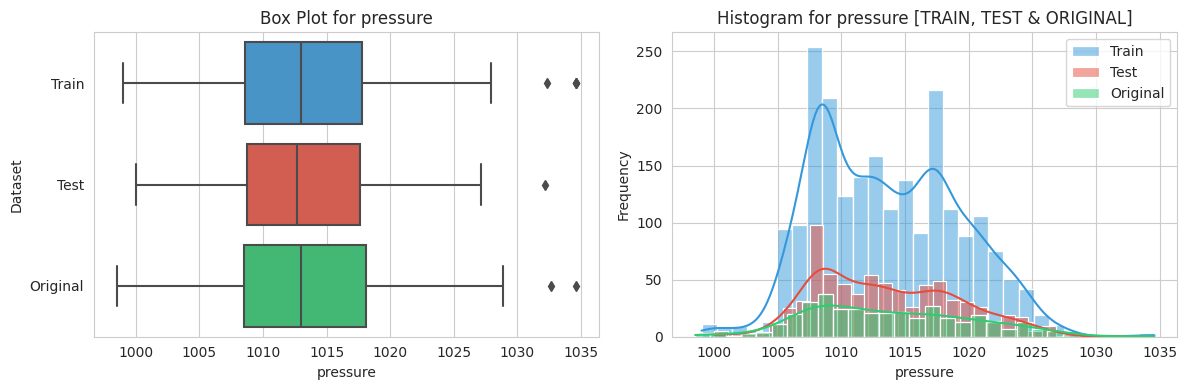

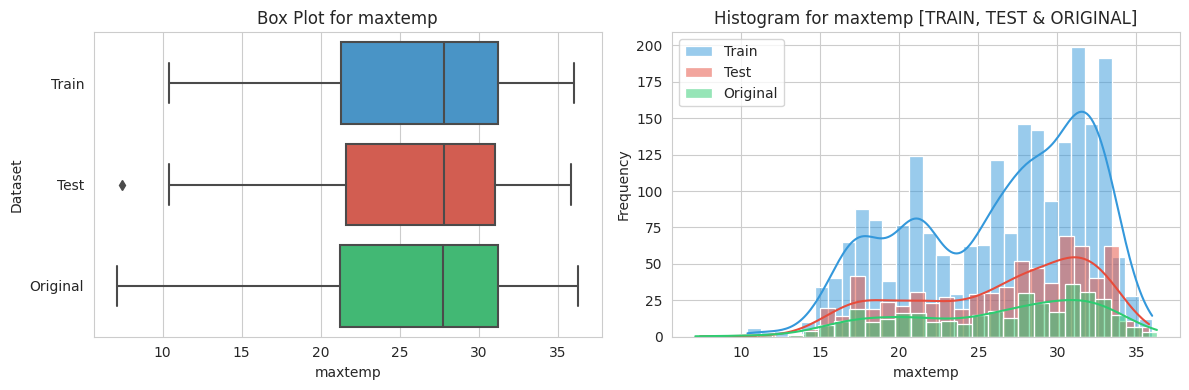

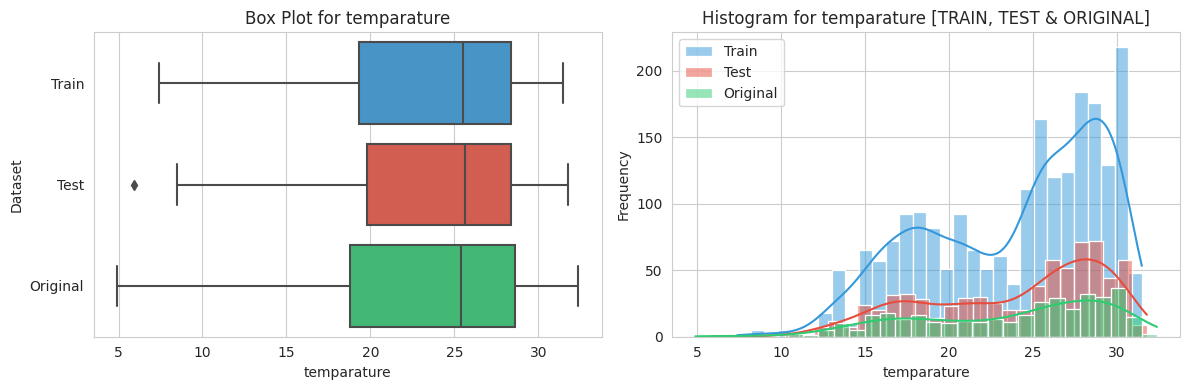

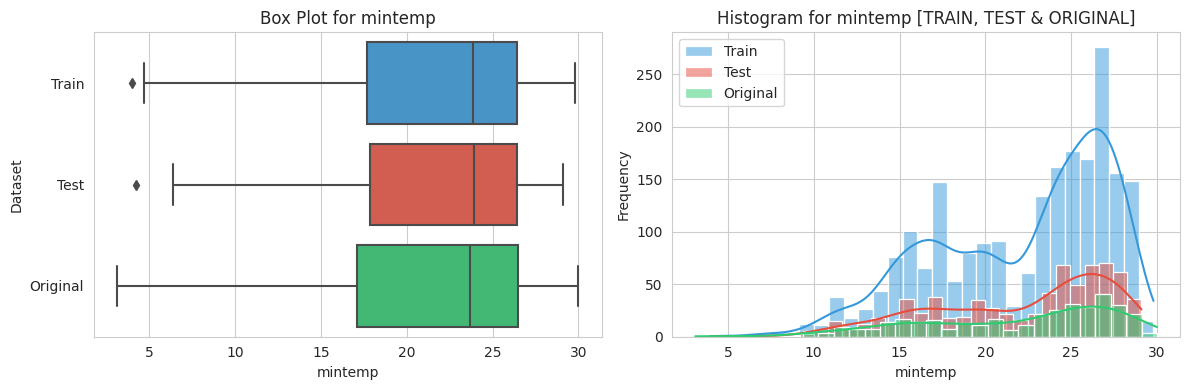

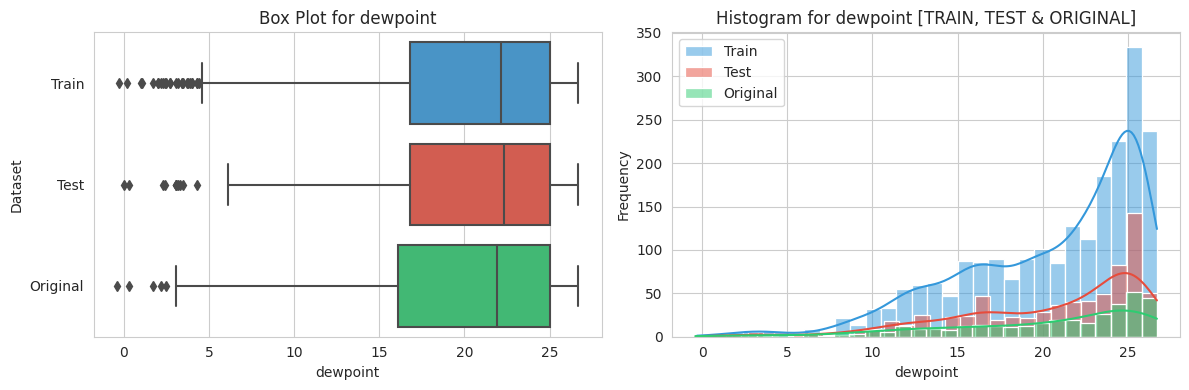

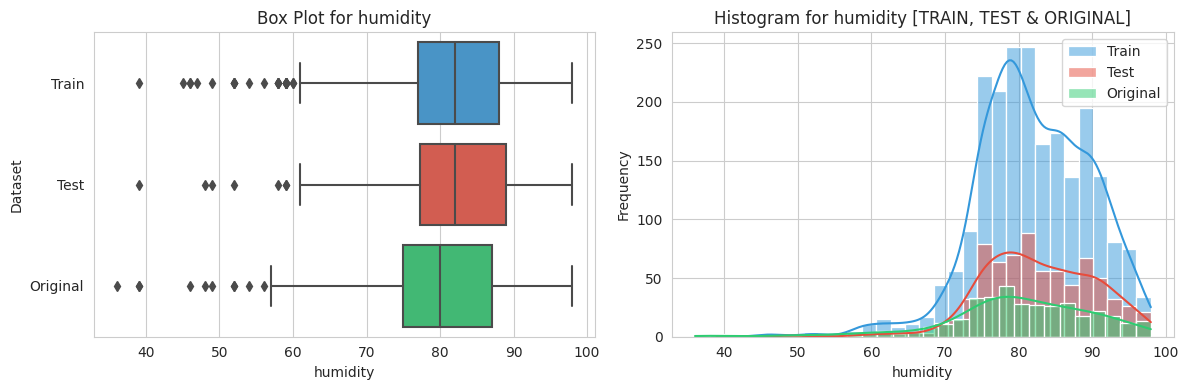

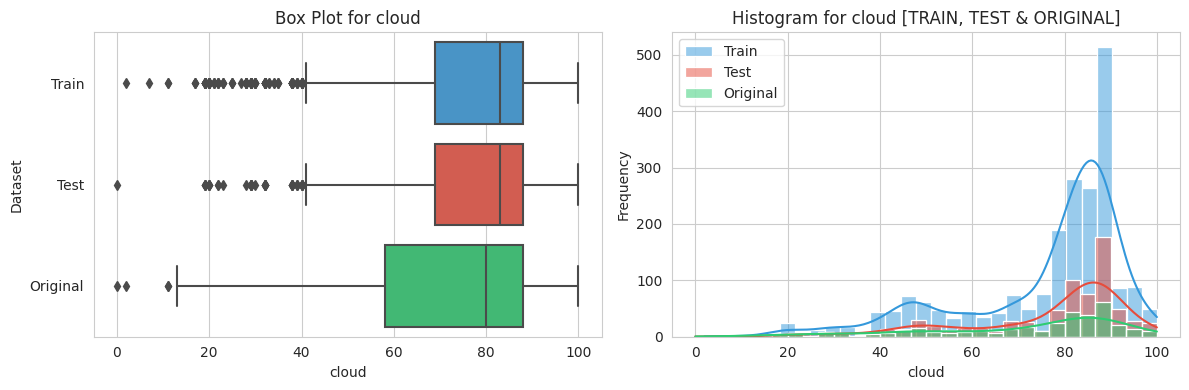

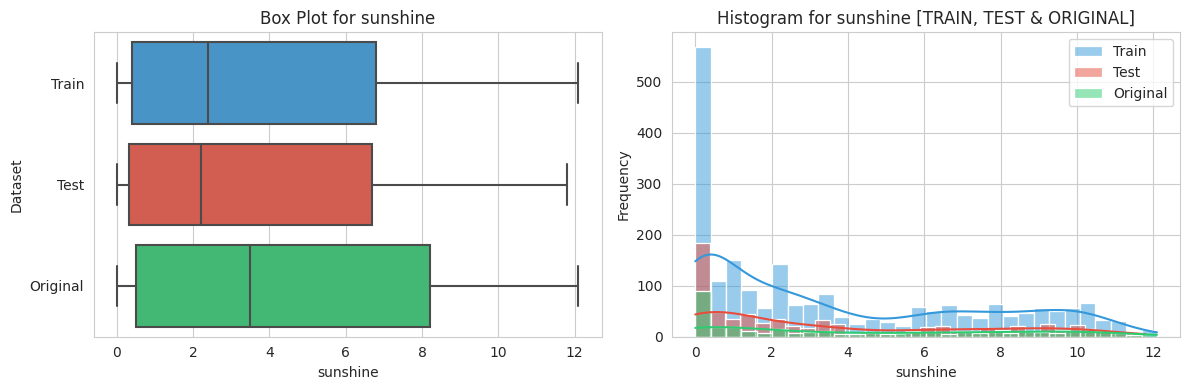

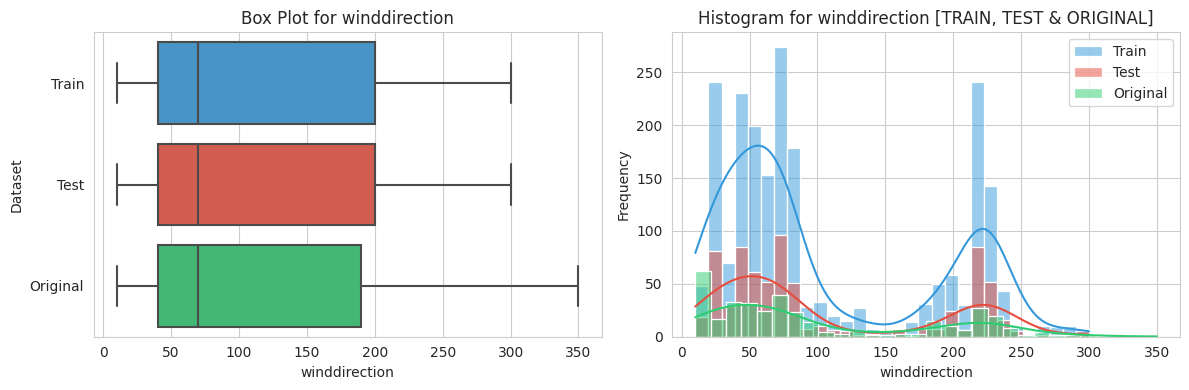

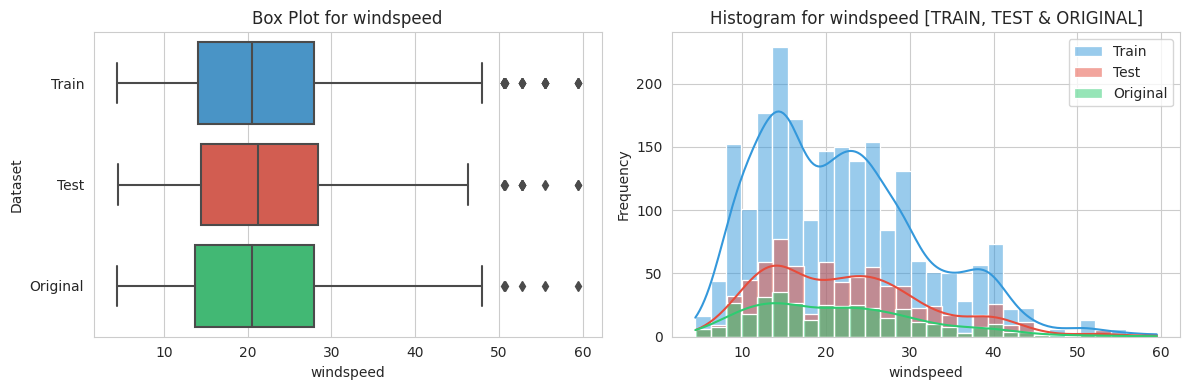

In [93]:
# Analysis of all NUMERICAL features

# Define a custom color palette
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

# Add 'Dataset' column to distinguish between train and test data
train_data['Dataset'] = 'Train'
test_data['Dataset'] = 'Test'
original_data['Dataset'] = 'Original'

variables = [col for col in train_data.columns if col in numerical_variables]

# Function to create and display a row of plots for a single variable
def create_variable_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train_data, test_data,original_data.dropna()]), x=variable, y="Dataset", palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    # Separate Histograms
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_data, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
    sns.histplot(data=test_data, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
    sns.histplot(data=original_data.dropna(), x=variable, color=custom_palette[2], kde=True, bins=30, label="Original")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable} [TRAIN, TEST & ORIGINAL]")
    plt.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Perform univariate analysis for each variable
for variable in variables:
    create_variable_plots(variable)

# Drop the 'Dataset' column after analysis
train_data.drop('Dataset', axis=1, inplace=True)
test_data.drop('Dataset', axis=1, inplace=True)
original_data.drop('Dataset', axis=1, inplace=True)

<div style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 20px; border-radius: 8px; font-size: 14px; color: #000000;">
  <h3 style="font-size: 20px; margin-bottom: 10px;">📝 <strong>Key Insights</strong></h3>
  <hr>

  <p><strong>1️⃣ Atmospheric Pressure (<code>pressure</code>) 🌡️</strong></p>
  <ul>
      <li>Distribution is <strong>close to normal</strong>, centered around <strong>1013 hPa</strong>.</li>
      <li>Few <strong>outliers (>1030 hPa)</strong> may indicate high-pressure systems.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Consider <strong>smoothing extreme values</strong>.</p>
  <hr>

  <p><strong>2️⃣ Max Temperature (<code>maxtemp</code>) ☀️</strong></p>
  <ul>
      <li>Left-skewed with <strong>two peaks</strong>, suggesting seasonal variations.</li>
      <li>A <strong>few outliers (~10°C)</strong> likely represent rare cold days.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Consider <strong>binning into temperature ranges</strong> to capture seasonality.</p>
  <hr>

  <p><strong>3️⃣ Average Temperature (<code>temperature</code>) 🌡️</strong></p>
  <ul>
      <li>Left-skewed with <strong>two peaks</strong>, suggesting distinct seasonal patterns.</li>
      <li>Some outliers <strong>(~7°C - 10°C)</strong> indicate rare cold spells.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Use <strong>season-based feature engineering</strong> for better predictions.</p>
  <hr>

  <p><strong>4️⃣ Minimum Temperature (<code>mintemp</code>) ❄️</strong></p>
  <ul>
      <li>Left-skewed distribution, indicating <strong>warm nights are more common</strong>.</li>
      <li>Some <strong>low-end outliers (~4°C - 7°C)</strong> suggest rare cold nights.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Consider <strong>outlier treatment</strong> to handle extreme cold values.</p>
  <hr>

  <p><strong>5️⃣ Dew Point (<code>dewpoint</code>) 💧</strong></p>
  <ul>
      <li>Left-skewed, with most values around <strong>20°C - 25°C</strong>.</li>
      <li>Presence of <strong>low outliers (~0°C - 5°C)</strong> suggests occasional dry conditions.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Consider <strong>log transformation</strong> to reduce skewness.</p>
  <hr>

  <p><strong>6️⃣ Humidity (<code>humidity</code>) 🌫️</strong></p>
  <ul>
      <li>Left-skewed distribution, with most values <strong>above 70%</strong>.</li>
      <li>Some <strong>low-end outliers (~40% - 50%)</strong> indicate dry periods.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Investigate <strong>dry season effects</strong> on model predictions.</p>
  <hr>

  <p><strong>7️⃣ Cloud Cover (<code>cloud</code>) ☁️</strong></p>
  <ul>
      <li>Left-skewed, peaking at <strong>80%-100%</strong>.</li>
      <li>Low-end outliers <strong>(0% - 30%)</strong> indicate occasional clear sky days.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Consider <strong>categorizing cloud cover</strong> into low, medium, and high groups.</p>
  <hr>

  <p><strong>8️⃣ Sunshine Duration (<code>sunshine</code>) 🌞</strong></p>
  <ul>
      <li>Highly right-skewed, with many values <strong>close to 0</strong>.</li>
      <li>Some <strong>high-end outliers (~10-12 hours of sunshine)</strong> indicate clear days.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Consider <strong>binning sunshine levels</strong> to distinguish clear vs. cloudy days.</p>
  <hr>

  <p><strong>9️⃣ Wind Direction (<code>winddirection</code>) 🌬️</strong></p>
  <ul>
      <li><strong>Bimodal distribution</strong>, suggesting two dominant wind patterns <strong>(~50° and ~200°)</strong>.</li>
      <li>Other directions occur <strong>less frequently</strong>.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Use <strong>one-hot encoding</strong> to capture wind patterns effectively.</p>
  <hr>

  <p><strong>🔟 Wind Speed (<code>windspeed</code>) 🍃</strong></p>
  <ul>
      <li>Right-skewed, with most values <strong>below 30 km/h</strong>.</li>
      <li>Outliers <strong>above 45 km/h</strong> suggest occasional storms or high-wind events.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Consider <strong>log transformation</strong> to reduce skewness.</p>

</div>

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [3.2] Target Feature Analysis (Univariate Analysis)</span></b>

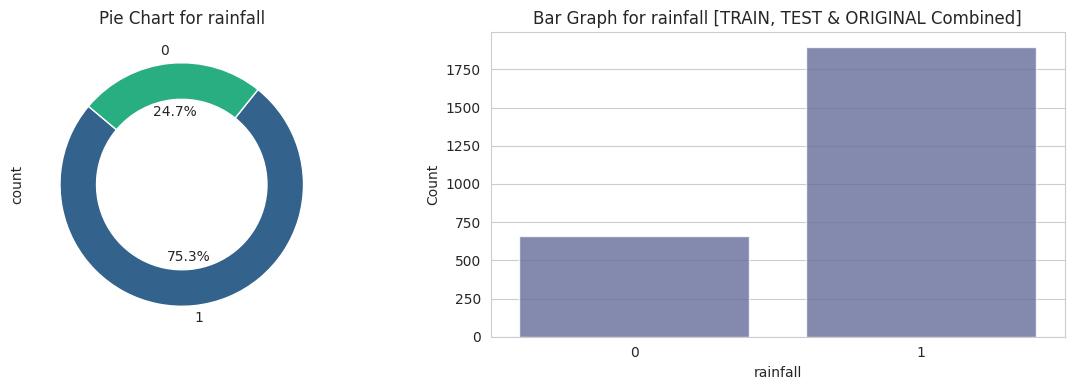

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pie_chart_palette = ['#33638d', '#28ae80', '#d3eb0c', '#ff9a0b', '#7e03a8', '#35b779', '#fde725', '#440154', '#90d743', '#482173', '#22a884', '#f8961e']

countplot_color = '#5C67A3'

# Function to create and display a row of plots for a single target variable
def create_target_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Pie Chart
    plt.subplot(1, 2, 1)
    train_data[variable].value_counts().plot.pie(
        autopct='%1.1f%%', colors=pie_chart_palette, wedgeprops=dict(width=0.3), startangle=140
    )
    plt.title(f"Pie Chart for {variable}")

    # Bar Graph
    plt.subplot(1, 2, 2)
    sns.countplot(
        data=pd.concat([train_data, original_data.dropna()]), 
        x=variable, 
        color=countplot_color,  # Using a single color for the countplot
        alpha=0.8  # Setting 80% opacity
    )
    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title(f"Bar Graph for {variable} [TRAIN, TEST & ORIGINAL Combined]")

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plots
    plt.show()

# Perform univariate analysis for target variable
create_target_plots(target_variable)

<div style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 20px; border-radius: 8px; font-size: 14px; color: #000000;">
    <h3 style="font-size: 20px; margin-bottom: 10px;">📝 <strong>Key Insights</strong></h3>
    <hr>
  <p><strong>1️⃣ Class Imbalance Detected ⚠️</strong></p>
  <ul>
      <li>The dataset is imbalanced, with ~75.3% rainy days (1) and ~24.7% non-rainy days (0).</li>
      <li>This suggests that a simple classifier might predict "rain" more often, leading to biased results.</li>
   </ul>
  <p><strong>2️⃣ Imbalanced Data May Affect Model Performance 📉</strong></p>
  <ul>
      <li>Since the data is skewed toward rainy days, models may struggle to correctly predict non-rainy days.</li>
      <li>We might need resampling techniques (e.g., SMOTE, undersampling) or adjusted class weights to improve balance.</li>
  </ul>
</div>

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [3.4] Bivariate Analysis (**상관관계 파악**)</span></b>

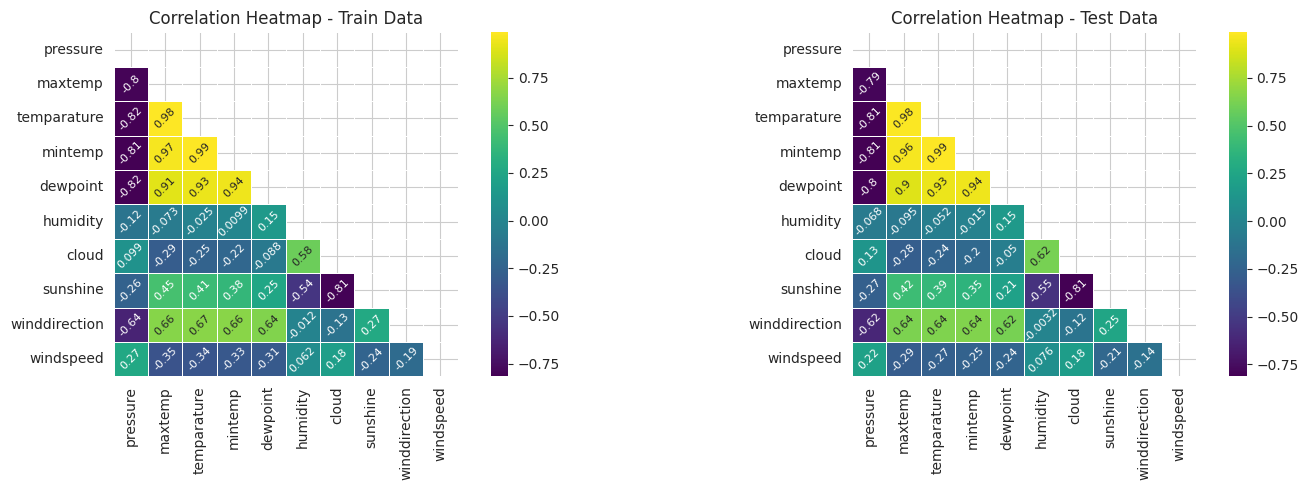

In [95]:
variables = [col for col in train_data.columns if col in numerical_variables]

# Adding variables to the existing list
train_variables = variables 
test_variables = variables

# Calculate correlation matrices for train_data and test_data
corr_train = train_data[train_variables].corr()
corr_test = test_data[test_variables].corr()

# Create masks for the upper triangle
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))

# Set the text size and rotation
annot_kws = {"size": 8, "rotation": 45}

# Generate heatmaps for train_data
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax_train = sns.heatmap(corr_train, mask=mask_train, cmap='viridis', annot=True,
                      square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Train Data')

# Generate heatmaps for test_data
plt.subplot(1, 2, 2)
ax_test = sns.heatmap(corr_test, mask=mask_test, cmap='viridis', annot=True,
                     square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Test Data')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

<Figure size 1000x600 with 0 Axes>

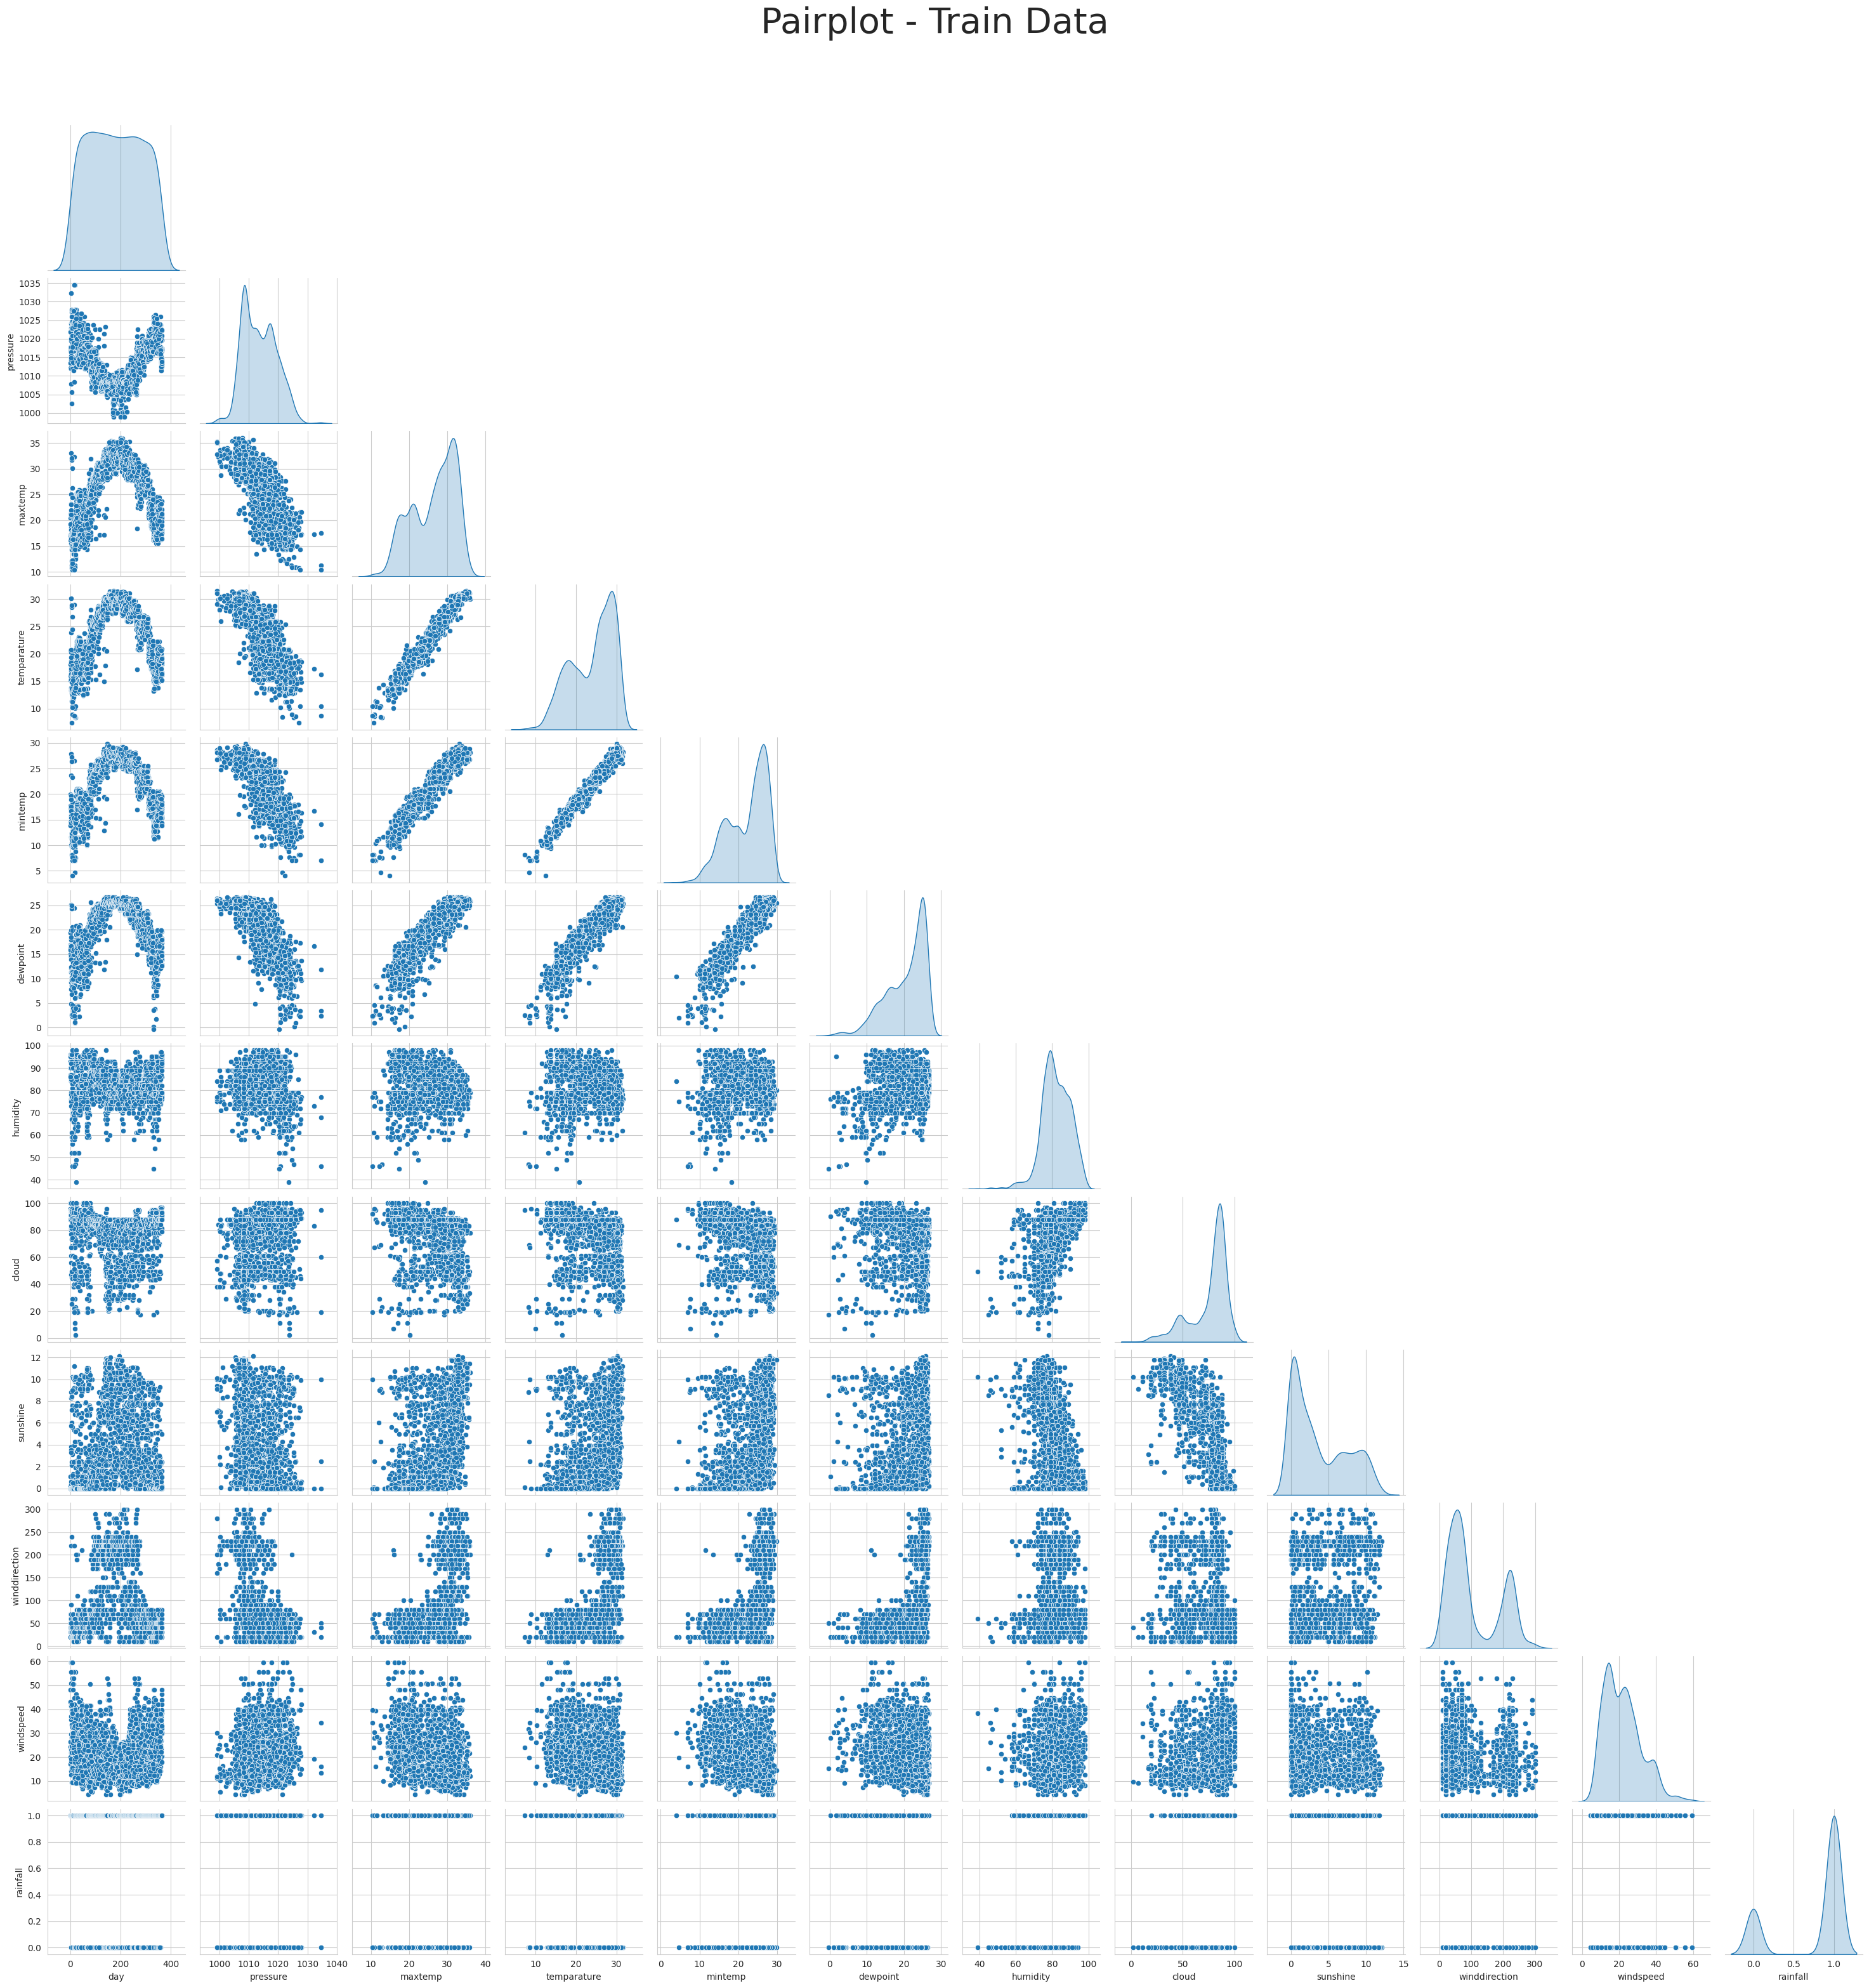

<Figure size 1000x600 with 0 Axes>

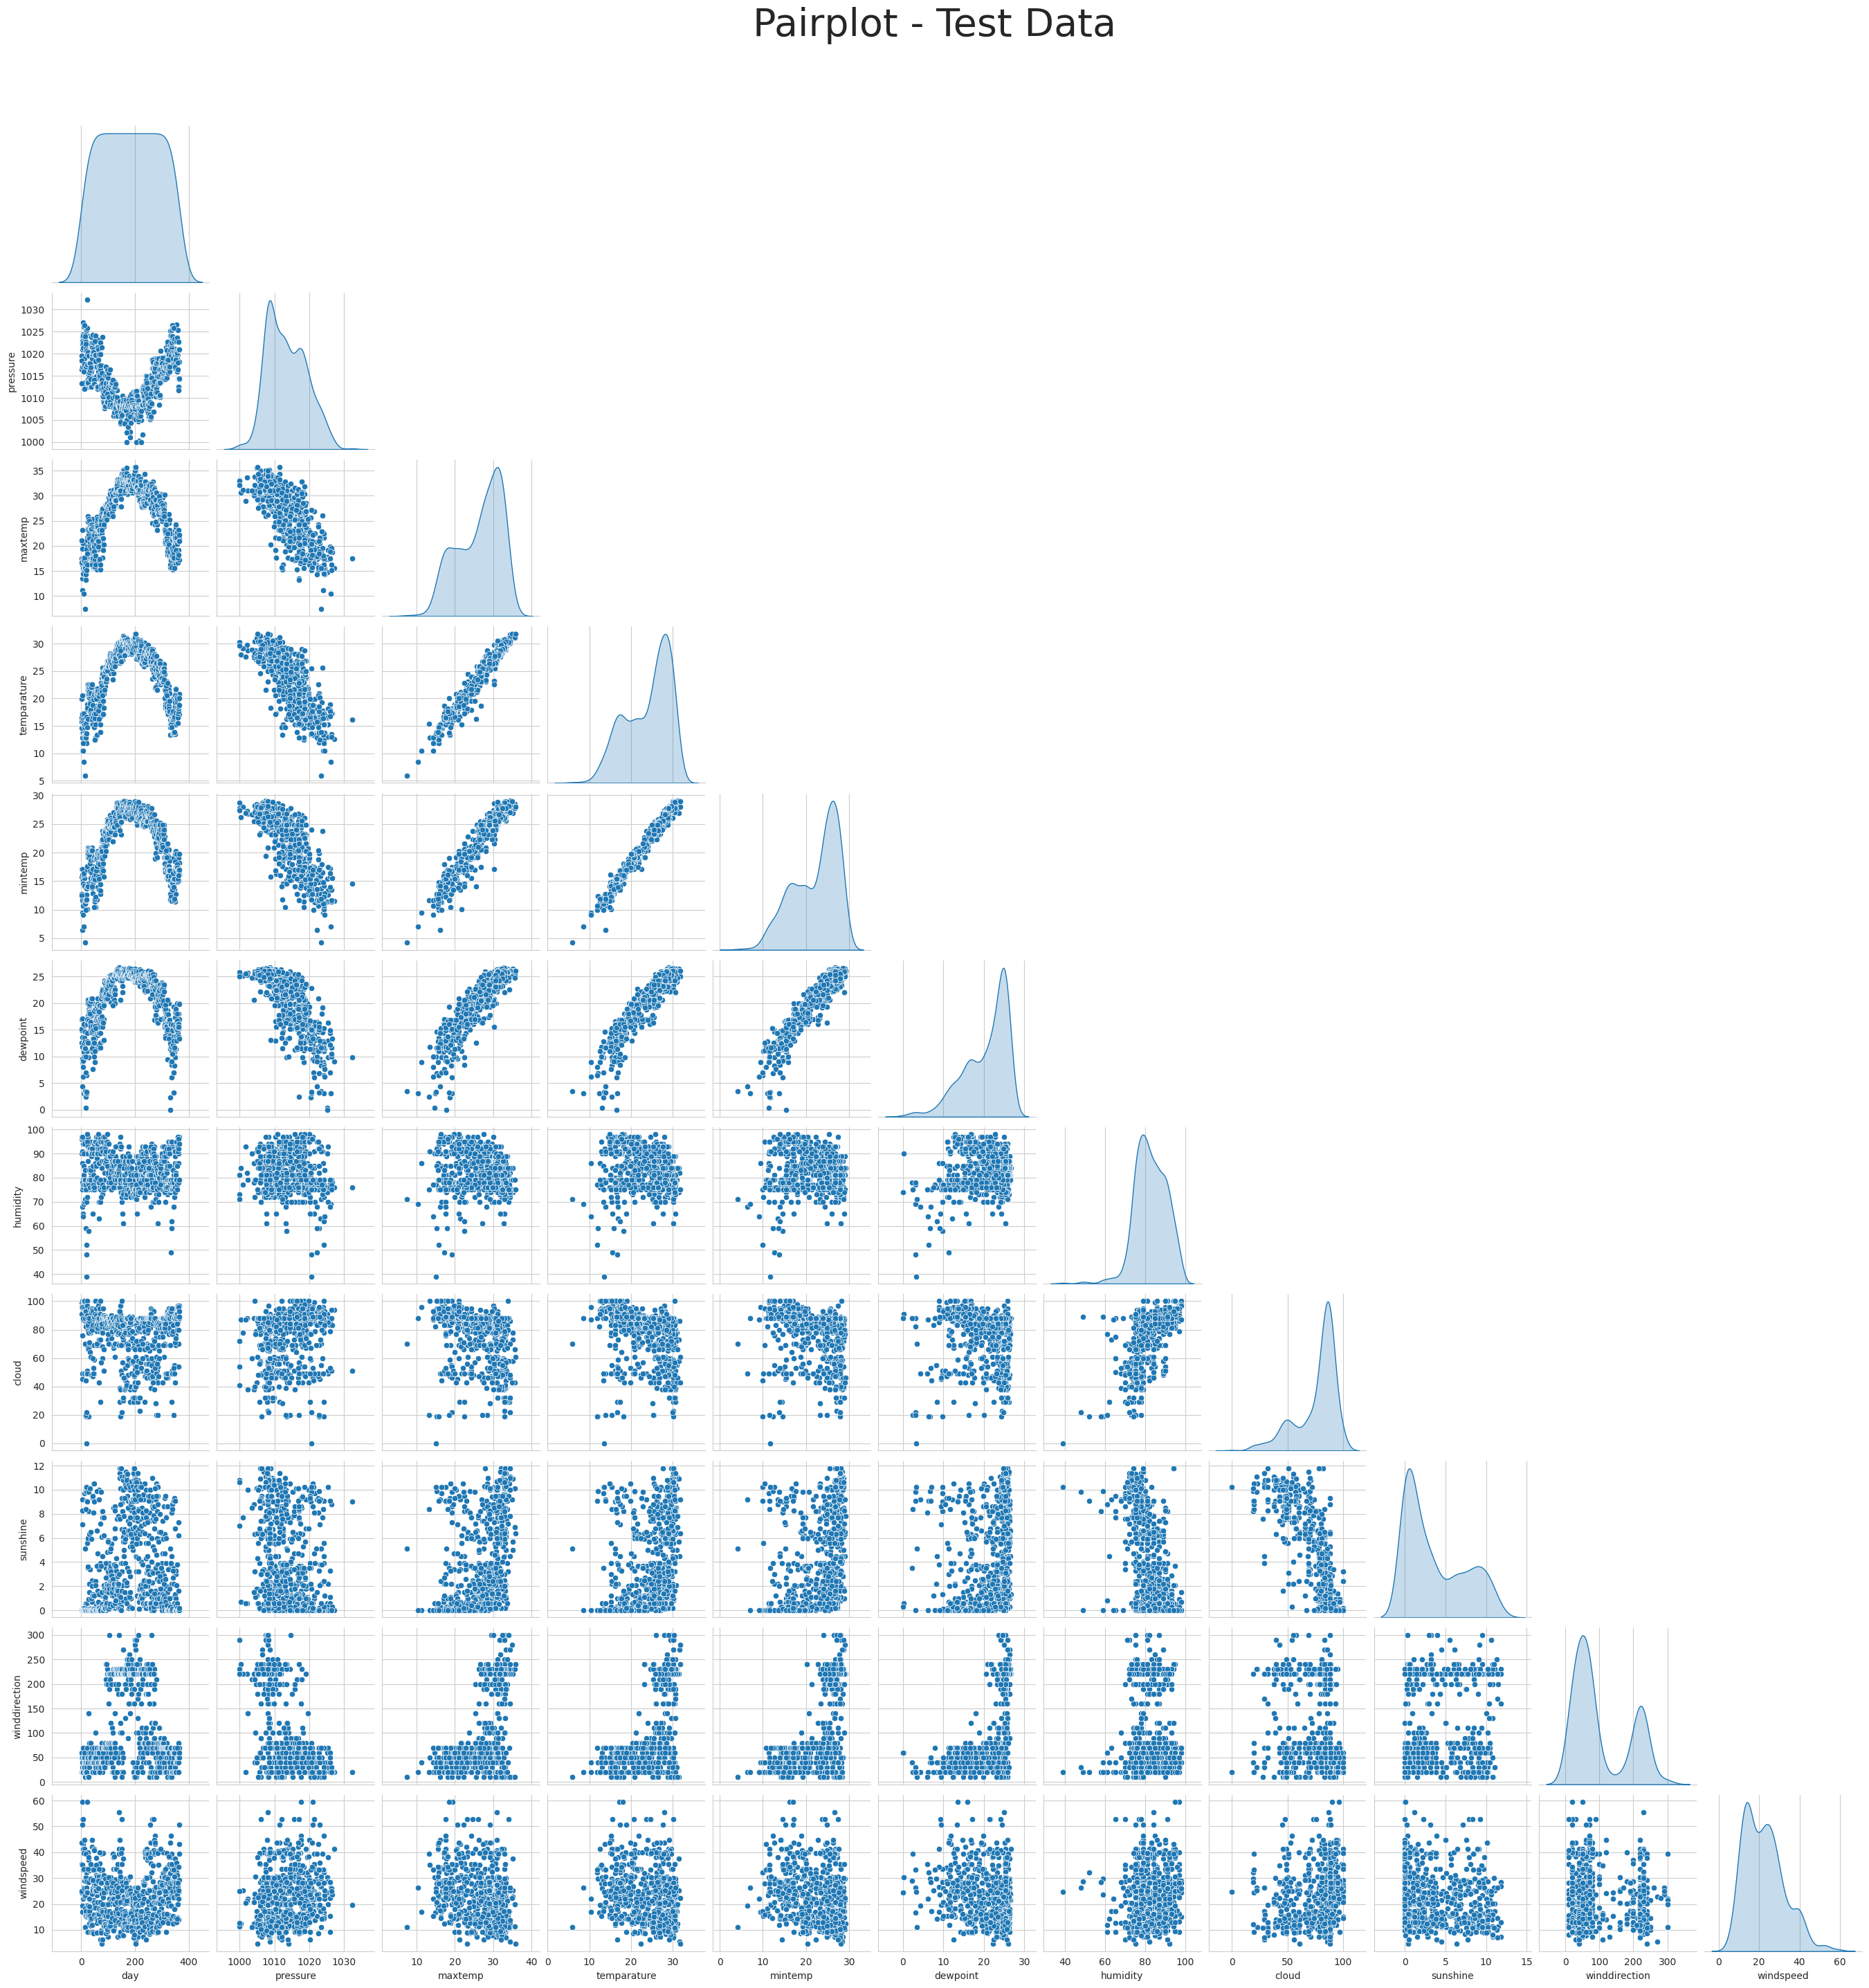

In [96]:
# Generate pairplot for train_data
plt.figure(figsize=(10, 6))
sns.pairplot(train_data.drop(columns=['id'], errors='ignore'), diag_kind="kde", corner=True)
plt.suptitle("Pairplot - Train Data", fontsize=40, y=1.05)
plt.show()

# Generate pairplot for test_data
plt.figure(figsize=(10, 6))
sns.pairplot(test_data.drop(columns=['id'], errors='ignore'), diag_kind="kde", corner=True)
plt.suptitle("Pairplot - Test Data", fontsize=40, y=1.05)
plt.show()

<div style="background-color:  #E8F8F5; border-left: 8px solid #1ABC9C; padding: 20px; border-radius: 8px; font-size: 14px; color: #000000;">
  <h3 style="font-size: 20px; margin-bottom: 10px;">📝 <strong>Key Insights</strong></h3>
  <hr>

  <p><strong>1️⃣ Strong Temperature Correlations 🌡️</strong></p>
  <ul>
      <li><code>maxtemp</code>, <code>temperature</code>, and <code>mintemp</code> are <strong>highly correlated</strong> (~0.97 - 0.99).</li>
      <li>This indicates <strong>redundancy</strong>, meaning one or two features could be removed without much information loss.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> To consider <strong>feature selection</strong> or <strong>PCA</strong> to reduce dimensionality.</p>
  <hr>

  <p><strong>2️⃣ Cloud Cover & Humidity Relationship 💧</strong></p>
  <ul>
      <li><code>Cloud Cover</code> and <code>humidity</code> show a <strong>strong correlation</strong> (~0.58).</li>
      <li>Higher cloud cover values are <strong>associated with increased humidity levels</strong>.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> These features provide similar information; <strong>scaling or transformation may help improve model performance</strong>.</p>
  <hr>

  <p><strong>3️⃣ Cloud Cover vs. Sunshine ☀️☁️</strong></p>
  <ul>
      <li>There is a <strong>strong negative correlation</strong> (~-0.81) between <code>cloud</code> and <code>sunshine</code>.</li>
      <li>This confirms that <strong>higher cloud cover significantly reduces sunshine exposure</strong>.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> <strong>Feature selection</strong> may be necessary, as <strong>both variables carry similar information</strong>.</p>
  <hr>

  <p><strong>4️⃣ Wind Speed & Cloud Cover 🌬️</strong></p>
  <ul>
      <li>A weak <strong>positive correlation</strong> (~-0.18) between <code>windspeed</code> and <code>cloud</code> suggests that stronger winds may <strong>reduce cloud formation</strong>.</li>
      <li>Higher wind speeds <strong>could disperse clouds</strong>, leading to clearer skies.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> Investigate <strong>wind-cloud interactions</strong> for additional feature engineering.</p>
  <hr>

  <p><strong>5️⃣ Weak Correlation Between Temperature & Humidity 🌡️💦</strong></p>
  <ul>
      <li><code>temperature</code> and <code>humidity</code> have a <strong>weak negative correlation</strong> (~-0.025).</li>
      <li>This implies that <strong>humidity levels are influenced by other factors beyond just temperature</strong>, such as wind and pressure.</li>
  </ul>
  <hr>

  <p><strong>6️⃣ Wind Direction & Wind Speed 💨</strong></p>
  <ul>
      <li><code>winddirection</code> and <code>windspeed</code> show a <strong>moderate negative correlation</strong> (~-0.19).</li>
      <li>Certain wind directions may be associated with <strong>stronger or weaker winds</strong>.</li>
  </ul>
  <p>✅ <strong>Next Steps:</strong> <strong>Categorizing wind direction</strong> may provide better insights for modeling.</p>
  
</div>

# <span style="color:#ffffff; font-size: 1%;">[4] 🛠️ Data Preprocessing</span>

<div style=" border-bottom: 8px solid #FFD700; overflow: hidden; border-radius: 10px; height: 45px; width: 100%; display: flex;">
  <div style="height: 100%; width: 65%; background-color: #7851A9; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 25px; ">
    <b><span style="color: #FFFFFF; padding: 20px 20px;">[4] 🛠️🧹 Data Preprocessing</span></b>
  </div>
  <div style="height: 100%; width: 35%; background-image: url('https://images.theconversation.com/files/436774/original/file-20211209-172173-1watr8u.jpg?ixlib=rb-4.1.0&rect=7%2C29%2C4881%2C3224&q=20&auto=format&w=320&fit=clip&dpr=2&usm=12&cs=strip'); background-size: cover; background-position: center; float: left; border-top-right-radius: 10px; border-bottom-right-radius: 4px;">
  </div>
</div>

> #### 🔧 **How Will We Fix It?**  
We'll use the **median imputation method** to fill in the missing value. Why median? Because **wind direction is a circular variable** (0° to 360°), and the median is more **robust to skewed distributions or extreme values**.  

In [97]:
# Impute the missing value with the median
test_data['winddirection'].fillna(test_data['winddirection'].median(), inplace=True)

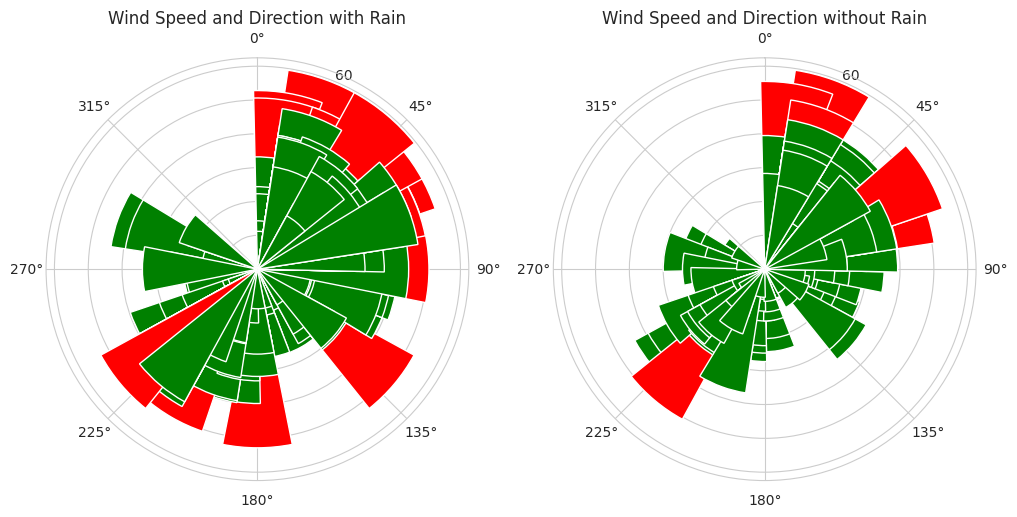

In [98]:
from matplotlib.projections import PolarAxes
from matplotlib.colors import to_rgba

# 비가 오는 경우와 오지 않는 경우 데이터 분리
train_rain = train_data[train_data['rainfall'] == 1]
train_norain = train_data[train_data['rainfall'] == 0]

# 1️⃣ 풍속에 따라 색상을 결정하는 함수 정의
def get_bar_color(windspeed):
    if windspeed < 3:  # Low wind speed
        return 'blue'
    elif windspeed < 50:  # Moderate wind speed
        return 'green'
    else:  # High wind speed
        return 'red'

# 2️⃣ 각 데이터에 대해 풍속 기반 색상 리스트 생성
rain_colors = [get_bar_color(ws) for ws in train_rain['windspeed']]
norain_colors = [get_bar_color(ws) for ws in train_norain['windspeed']]

# 극좌표 플롯 생성
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(12, 6))

# 첫 번째 플롯: 비가 올 때의 풍속/풍향
ax1 = axes[0]
ax1.set_theta_direction(-1)  # 시계 방향
ax1.set_theta_offset(np.pi / 2.0)  # 90도 회전하여 북쪽이 위로 가도록 설정
bars1 = ax1.bar(
    np.deg2rad(train_rain['winddirection']),  # 풍향을 라디안 값으로 변환
    train_rain['windspeed'],  # 풍속
    width=np.pi/8,  # 막대 너비 설정
    bottom=0.0,
    color=rain_colors  # 3️⃣ 동적으로 생성된 색상 리스트 적용
)
ax1.set_title('Wind Speed and Direction with Rain')

# 두 번째 플롯: 비가 오지 않을 때의 풍속/풍향
ax2 = axes[1]
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2.0)
bars2 = ax2.bar(
    np.deg2rad(train_norain['winddirection']),
    train_norain['windspeed'],
    width=np.pi/8,
    bottom=0.0,
    color=norain_colors  # 3️⃣ 여기도 동적으로 색상 적용
)
ax2.set_title('Wind Speed and Direction without Rain')

plt.show()


> 1. 비가 올 때: 초록색 막대가 많이 분포되어 중간 정도의 풍속이 가장 흔하게 나타남을 알 수 있다, 비가올 때는 바람의 방향과 세기가 비교적 고르게 분포하는 경향이 있다.
> 3. 비가 오지 않을 때: 초록색과 빨간색 막대가 혼재되어 나타나며, 바람의 방향과 세기가 비교적 불규칙하게 분포하는 경향이 있다. 

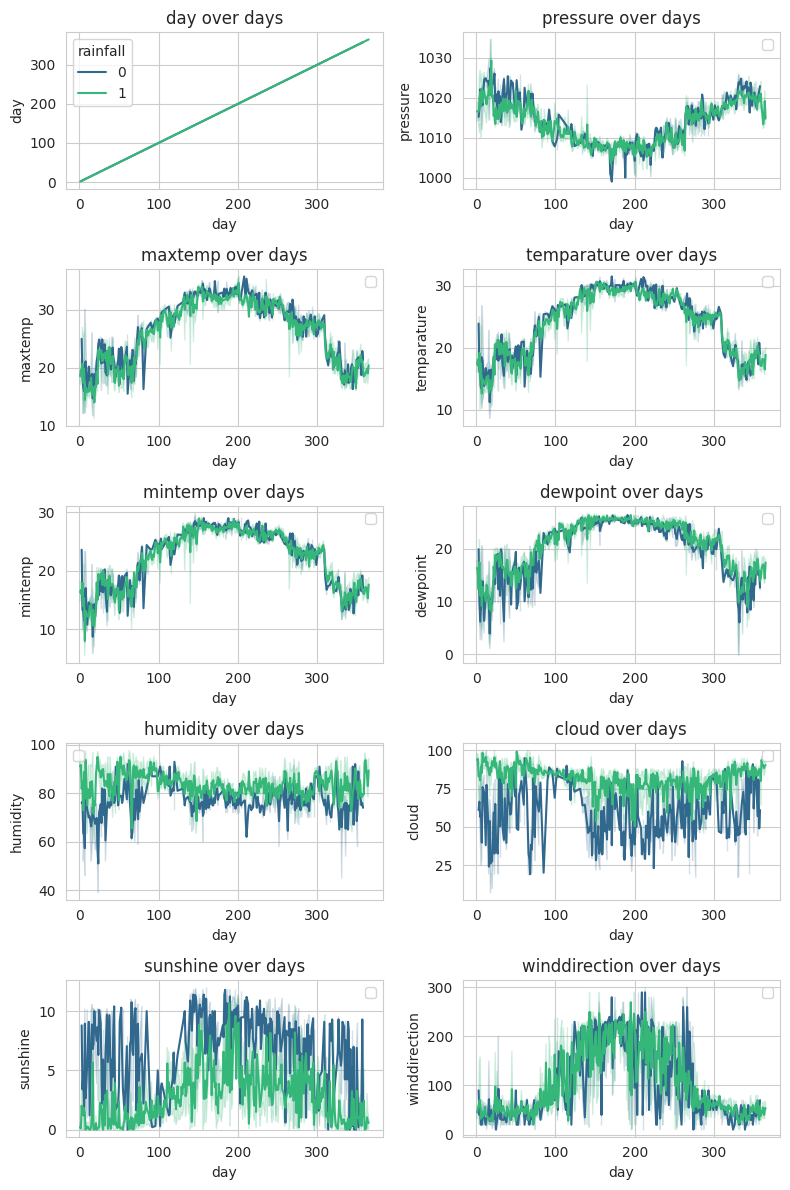

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, axes = plt.subplots(5, 2, figsize=(8, 12))

for i, feat in enumerate(test_data.columns[1:11]): # test_data.columns[1:11]로 수정
    row = i // 2
    col = i % 2
    sns.lineplot(train_data, x='day', y=feat, hue='rainfall', palette='viridis', ax=axes[row, col])
    if i != 0:
        axes[row, col].legend([])
    axes[row, col].set_title(f'{feat} over days', fontsize=12)

plt.tight_layout()
plt.show()

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [4.2] Feature Engineering </span></b>

In [100]:
def perform_feature_engineering(df):
    # Temperature Difference - Difference between max and min temperature
    df['Temp_Diff'] = df['maxtemp'] - df['mintemp']

    # Dew Point Spread - Difference between temperature and dew point
    df['Dew_Point_Spread'] = df['temparature'] - df['dewpoint']

    # Humidity Category - Binning humidity into low, medium, and high
    df['Humidity_Category'] = pd.cut(df['humidity'], bins=[0, 50, 80, 100], labels=['Low', 'Medium', 'High'])

    # Cloud Cover Category - Grouping cloud cover into bins
    df['Cloud_Cover_Category'] = pd.cut(df['cloud'], bins=[0, 30, 70, 100], labels=['Clear', 'Partly Cloudy', 'Overcast'])

    # Sunshine Duration Category - Categorizing sunshine duration
    df['Sunshine_Category'] = pd.cut(df['sunshine'], bins=[0, 3, 7, 12], labels=['Low', 'Medium', 'High'])

    # Wind Speed Intensity - Categorizing wind speeds
    df['Wind_Speed_Intensity'] = pd.cut(df['windspeed'], bins=[0, 10, 25, 60], labels=['Calm', 'Breezy', 'Windy'])

    # Wind Direction Grouping - Binning wind direction into 4 quadrants
    df['Wind_Quadrant'] = pd.cut(df['winddirection'], bins=[0, 90, 180, 270, 360], labels=['NE', 'SE', 'SW', 'NW'], include_lowest=True)

    # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
    df['Pressure_Humidity_Interaction'] = df['pressure'] * df['humidity']

    # Interaction Feature: Wind & Cloud Cover - Wind effect on cloud cover
    df['Wind_Cloud_Interaction'] = df['windspeed'] * df['cloud']

    # Temperature Ratio - Normalized temperature based on max recorded value
    df['Temp_Ratio'] = df['temparature'] / df['maxtemp'].max()

      # Month: day 값을 12개의 구간으로 나누고 (연간 월 간격), 각 구간에 1~12의 월 번호를 할당
    df['month'] = pd.cut(df['day'], bins=12, labels=range(1, 13)).astype('int')

    # 과거 데이터 활용 변수 생성, 하루 전의 온도를 가져온다. 즉, 이전 행의 값을 참조(shift(1)하는데, 첫 번째 행은 이전 값이 없기 때문에 결측값으로 처리되므로, 이를 0으로 대체.
    df['temp_previous_day'] = df['temparature'].shift(1).fillna(0)

    # 하루 전의 습도를 가져오기
    df['humidity_previous_day'] = df['humidity'].shift(1).fillna(0)

    # 하루 전의 기압 가져오기
    df['pressure_previous_day'] = df['pressure'].shift(1).fillna(0)

    # day 함수 => 계절적인 파생 변수 생성(계절성 반영)
    df['Day_sin'] = np.sin(2 * np.pi * df['day']/365)
    df['Day_cos'] = np.cos(2 * np.pi * df['day']/365)

    # 풍향/풍속 벡터화 
    df['Wind_U'] = df['windspeed'] * np.cos(np.radians(df['winddirection']))
    df['Wind_V'] = df['windspeed'] * np.sin(np.radians(df['winddirection']))
    # Wind_U: 동-서 방향의 바람 (양수면 동쪽, 음수면 서쪽)
    # Wind_V: 북-남 방향의 바람 (양수면 북쪽, 음수면 남쪽)
    # 풍향을 범주형 변수로 변환하는 것보다 모델이 더 효과적으로 높을 수 있음? 비교 해봐야할 듯..
    
    return df

# Apply feature engineering to both train and test data
train_data = perform_feature_engineering(train_data)
test_data = perform_feature_engineering(test_data)

In [101]:
id_test = test_data['id']

columns_to_drop = ['id']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop, axis=1, inplace=True)

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [4.3] Outlier Detection </span></b>

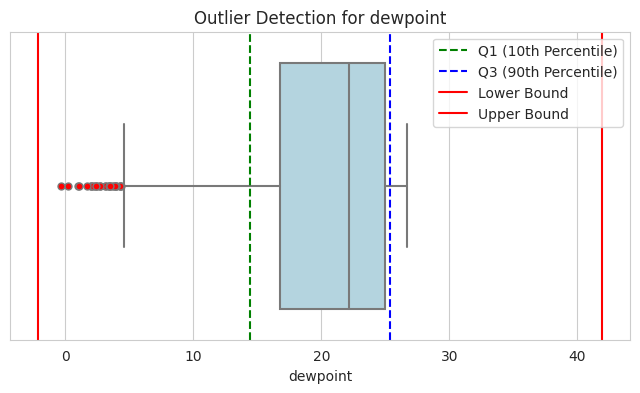

Rows deleted for dewpoint: 0


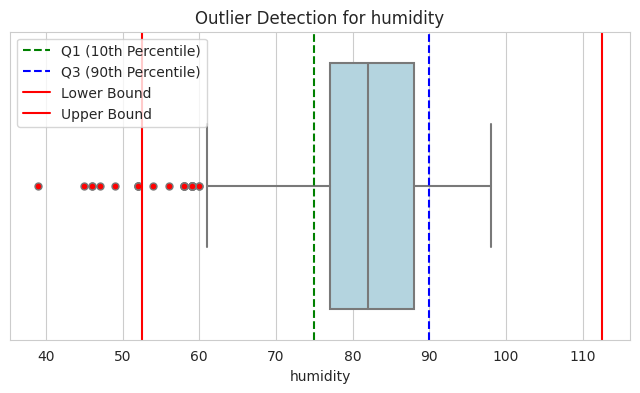

Rows deleted for humidity: 10


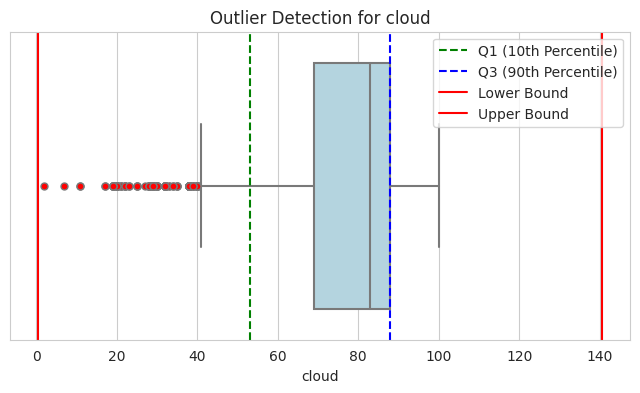

Rows deleted for cloud: 0


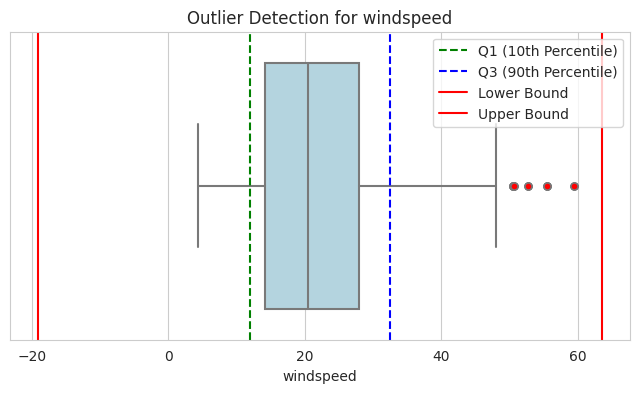

Rows deleted for windspeed: 0


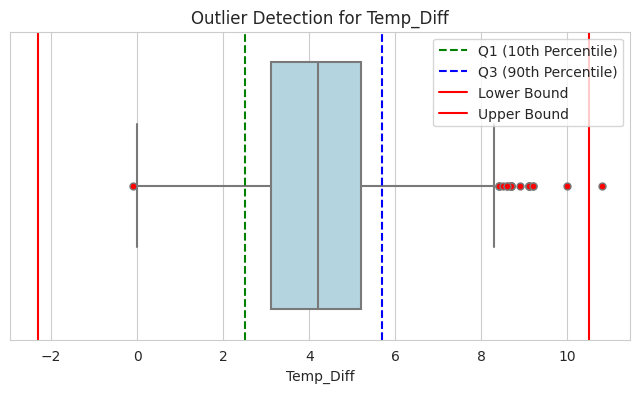

Rows deleted for Temp_Diff: 1


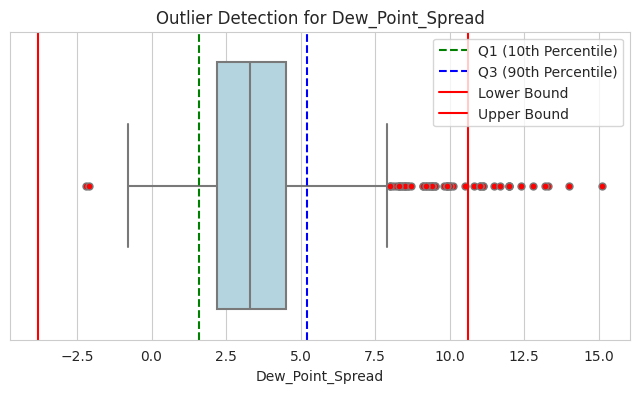

Rows deleted for Dew_Point_Spread: 16


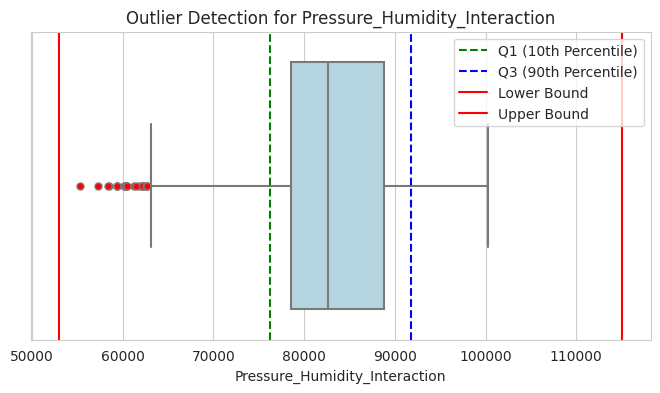

Rows deleted for Pressure_Humidity_Interaction: 0


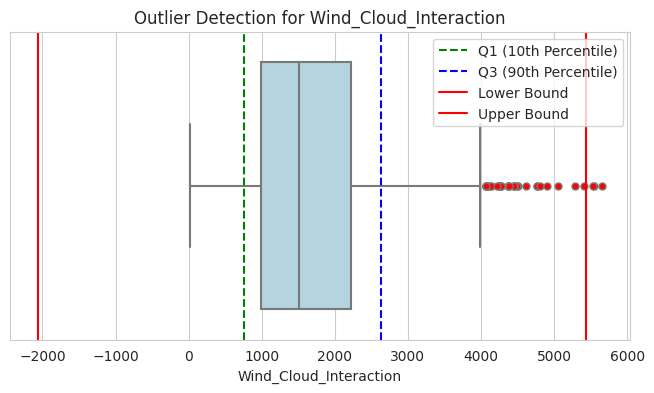

Rows deleted for Wind_Cloud_Interaction: 3


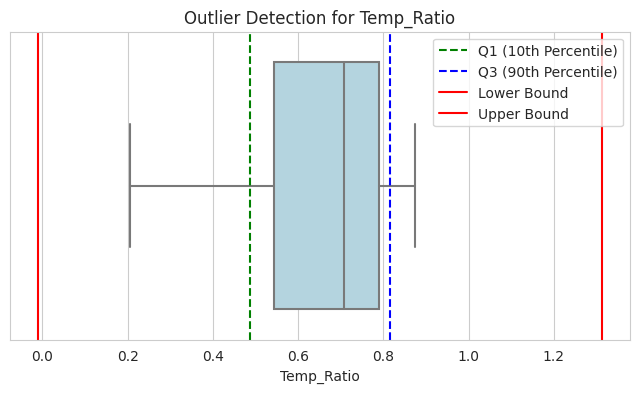

Rows deleted for Temp_Ratio: 0
Total rows deleted: 30


In [102]:
columns_to_check = ['dewpoint', 'humidity', 'cloud', 'windspeed', 'Temp_Diff', 'Dew_Point_Spread', 'Pressure_Humidity_Interaction', 'Wind_Cloud_Interaction', 'Temp_Ratio']

# Function to remove outliers using IQR and visualize
def remove_outliers_iqr_with_plot(data, column):
    Q1 = data[column].quantile(0.15)
    Q3 = data[column].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    # Calculate the number of rows deleted
    rows_deleted = len(data) - len(filtered_data)
    
    # Plot the distribution with outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column], color='lightblue', flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'})
    
    # Highlight Q1 and Q3
    plt.axvline(Q1, color='green', linestyle='--', label='Q1 (10th Percentile)')
    plt.axvline(Q3, color='blue', linestyle='--', label='Q3 (90th Percentile)')
    
    # Highlight lower and upper bounds
    plt.axvline(lower_bound, color='red', linestyle='-', label='Lower Bound')
    plt.axvline(upper_bound, color='red', linestyle='-', label='Upper Bound')

    plt.title(f'Outlier Detection for {column}')
    plt.legend()
    plt.xlabel(column)
    plt.show()
    
    return filtered_data, rows_deleted

# Apply function to each numerical column and visualize
rows_deleted_total = 0

for column in columns_to_check:
    train_data, rows_deleted = remove_outliers_iqr_with_plot(train_data, column)
    rows_deleted_total += rows_deleted
    print(f"Rows deleted for {column}: {rows_deleted}")

print(f"Total rows deleted: {rows_deleted_total}")

In [103]:
y = train_data['rainfall']

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [4.4] Transformation of Distributions </span></b>

In [104]:
# [FOR TRAIN]
# Identify features with skewness greater than 0.75
skewed_features = train_data[numerical_variables].skew()[train_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {feature} before log transformation')
    plt.show()

# Apply log1p transformation to skewed features
train_data[skewed_features] = np.log1p(train_data[skewed_features])

# Plot skewed features after transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[feature], bins=50, kde=True, color='green')
    plt.title(f'Distribution of {feature} after log transformation')
    plt.show()

Features to be transformed (skewness > 0.75):


array([], dtype=object)

> 왜곡도가 0.75를 초과하는 특성이 없다

Features to be transformed (skewness > 0.75):


array(['windspeed'], dtype=object)

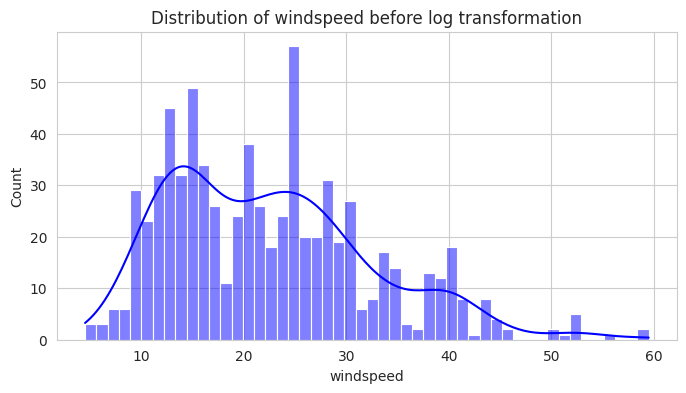

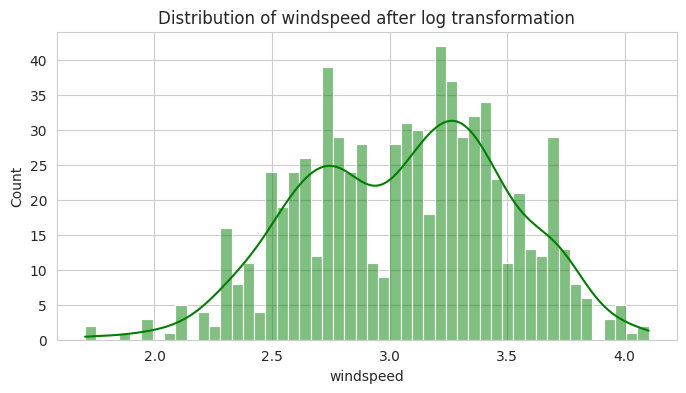

In [105]:
# [FOR TEST] 테스트 데이터(test_data)에서 왜곡된 수치형 특성을 찾아 로그 변환으로 분포 개선 
# Identify features with skewness greater than 0.75
skewed_features = test_data[numerical_variables].skew()[test_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(test_data[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {feature} before log transformation')
    plt.show()

# Apply log1p transformation to skewed features
test_data[skewed_features] = np.log1p(test_data[skewed_features])

# Plot skewed features after transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(test_data[feature], bins=50, kde=True, color='green')
    plt.title(f'Distribution of {feature} after log transformation')
    plt.show()

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [4.4] Feature Encoding </span></b>

In [106]:
# Selecting specific columns for encoding
columns_to_encode = ['Cloud_Cover_Category', 'Humidity_Category', 'Sunshine_Category', 'Wind_Quadrant','Wind_Speed_Intensity']
train_data_to_encode = train_data[columns_to_encode]
test_data_to_encode = test_data[columns_to_encode]

# Dropping selected columns for scaling
train_data_to_scale = train_data.drop(columns_to_encode, axis=1)
test_data_to_scale = test_data.drop(columns_to_encode, axis=1)

train_data_encoded = pd.get_dummies(train_data_to_encode, columns=columns_to_encode, drop_first=True)
test_data_encoded = pd.get_dummies(test_data_to_encode, columns=columns_to_encode, drop_first=True)

In [107]:
train_data_encoded.sample(3)

Cloud_Cover_Category_Partly Cloudy  Cloud_Cover_Category_Overcast  \
837                                False                           True   
1799                               False                           True   
1643                               False                           True   

      Humidity_Category_Medium  Humidity_Category_High  \
837                      False                    True   
1799                      True                   False   
1643                      True                   False   

      Sunshine_Category_Medium  Sunshine_Category_High  Wind_Quadrant_SE  \
837                       True                   False             False   
1799                     False                   False             False   
1643                      True                   False             False   

      Wind_Quadrant_SW  Wind_Quadrant_NW  Wind_Speed_Intensity_Breezy  \
837               True             False                         True   
1799             False             False                        False   
1643              True             False                         True   

      Wind_Speed_Intensity_Windy  
837                        False  
1799                        True  
1643                       False

In [108]:
test_data_encoded.sample(3)

Cloud_Cover_Category_Partly Cloudy  Cloud_Cover_Category_Overcast  \
189                               False                           True   
165                                True                          False   
323                               False                           True   

     Humidity_Category_Medium  Humidity_Category_High  \
189                      True                   False   
165                      True                   False   
323                     False                    True   

     Sunshine_Category_Medium  Sunshine_Category_High  Wind_Quadrant_SE  \
189                      True                   False             False   
165                     False                    True             False   
323                     False                   False             False   

     Wind_Quadrant_SW  Wind_Quadrant_NW  Wind_Speed_Intensity_Breezy  \
189              True             False                         True   
165              True             False                         True   
323             False             False                         True   

     Wind_Speed_Intensity_Windy  
189                       False  
165                       False  
323                       False

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [4.5] Feature Scaling </span></b>

In [109]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# MinMaxScaler 적용
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(train_data_to_scale.drop(['rainfall'], axis=1))  # 'rainfall' 열 제외하고 학습
scaled_data_train_minmax = minmax_scaler.transform(train_data_to_scale.drop(['rainfall'], axis=1))
scaled_train_df_minmax = pd.DataFrame(scaled_data_train_minmax, columns=train_data_to_scale.drop(['rainfall'], axis=1).columns)
scaled_data_test_minmax = minmax_scaler.transform(test_data_to_scale)
scaled_test_df_minmax = pd.DataFrame(scaled_data_test_minmax, columns=test_data_to_scale.columns)

# StandardScaler 적용
standard_scaler = StandardScaler()
standard_scaler.fit(train_data_to_scale.drop(['rainfall'], axis=1))  # 'rainfall' 열 제외하고 학습
scaled_data_train_standard = standard_scaler.transform(train_data_to_scale.drop(['rainfall'], axis=1))
scaled_train_df_standard = pd.DataFrame(scaled_data_train_standard, columns=train_data_to_scale.drop(['rainfall'], axis=1).columns)
scaled_data_test_standard = standard_scaler.transform(test_data_to_scale)
scaled_test_df_standard = pd.DataFrame(scaled_data_test_standard, columns=test_data_to_scale.columns)

# 결과 확인 (선택 사항)
print("MinMaxScaler scaled train data:")
print(scaled_train_df_minmax.head())

print("\nStandardScaler scaled train data:")
print(scaled_train_df_standard.head())

MinMaxScaler scaled train data:
        day  pressure   maxtemp  temparature   mintemp  dewpoint  humidity  \
0  0.000000  0.516854  0.421875     0.547718  0.605578  0.715953  0.750000   
1  0.002747  0.575843  0.226562     0.394191  0.442231  0.560311  0.931818   
2  0.005495  0.705056  0.351562     0.360996  0.394422  0.322957  0.477273   
3  0.008242  0.404494  0.300781     0.431535  0.486056  0.614786  0.931818   
4  0.013736  0.665730  0.398438     0.464730  0.470120  0.447471  0.568182   

      cloud  sunshine  winddirection  ...  Wind_Cloud_Interaction  Temp_Ratio  \
0  0.877551  0.090909       0.172414  ...                0.276982    0.547718   
1  0.908163  0.000000       0.137931  ...                0.365818    0.394191   
2  0.459184  0.685950       0.206897  ...                0.154116    0.360996   
3  0.948980  0.000000       0.172414  ...                0.623283    0.431535   
4  0.806122  0.000000       0.034483  ...                0.232146    0.464730   

   month  te

In [110]:
scaled_train_df_minmax.sample(3)

day  pressure   maxtemp  temparature   mintemp  dewpoint  humidity  \
1103  0.065934  0.615169  0.566406     0.443983  0.442231  0.634241  0.409091   
1661  0.612637  0.250000  0.820312     0.867220  0.868526  0.933852  0.613636   
1993  0.538462  0.238764  0.878906     0.925311  0.924303  0.910506  0.545455   

         cloud  sunshine  winddirection  ...  Wind_Cloud_Interaction  \
1103  0.387755  0.834711       0.000000  ...                0.143236   
1661  0.877551  0.264463       0.724138  ...                0.252516   
1993  0.367347  0.975207       0.689655  ...                0.118288   

      Temp_Ratio     month  temp_previous_day  humidity_previous_day  \
1103    0.443983  0.000000           0.660317               0.397959   
1661    0.867220  0.636364           0.882540               0.857143   
1993    0.925311  0.545455           0.955556               0.775510   

      pressure_previous_day   Day_sin   Day_cos    Wind_U    Wind_V  
1103               0.989368  0.708599  0.954408  0.665054  0.485494  
1661               0.974096  0.172419  0.122237  0.375057  0.338202  
1993               0.974386  0.376488  0.015477  0.347872  0.353898  

[3 rows x 24 columns]

In [111]:
scaled_test_df_minmax.sample(3)

day  pressure   maxtemp  temparature   mintemp  dewpoint  humidity  \
355  0.975275  0.547753  0.414062     0.560166  0.545817  0.634241  0.886364   
716  0.964286  0.561798  0.519531     0.597510  0.621514  0.665370  0.568182   
276  0.758242  0.317416  0.753906     0.788382  0.729084  0.879377  0.545455   

        cloud  sunshine  winddirection  ...  Wind_Cloud_Interaction  \
355  0.877551  0.000000       0.137931  ...                0.236206   
716  0.734694  0.000000       0.103448  ...                0.196690   
276  0.448980  0.132231       0.206897  ...                0.080848   

     Temp_Ratio     month  temp_previous_day  humidity_previous_day  \
355    0.565011  1.000000           0.549206               0.928571   
716    0.602564  1.000000           0.552381               0.836735   
276    0.794501  0.818182           0.787302               0.908163   

     pressure_previous_day   Day_sin   Day_cos    Wind_U    Wind_V  
355               0.984052  0.422845  0.994011  0.572606  0.570653  
716               0.986275  0.389038  0.987532  0.588568  0.550229  
276               0.977189  0.000778  0.527950  0.516835  0.549339  

[3 rows x 24 columns]

In [112]:
# Concatenate train datasets (MinMaxScaler)
train_data_combined_minmax = pd.concat([train_data_encoded.reset_index(drop=True), scaled_train_df_minmax.reset_index(drop=True)], axis=1)

# Concatenate test datasets (MinMaxScaler)
test_data_combined_minmax = pd.concat([test_data_encoded.reset_index(drop=True), scaled_test_df_minmax.reset_index(drop=True)], axis=1)

# Concatenate train datasets (StandardScaler)
train_data_combined_standard = pd.concat([train_data_encoded.reset_index(drop=True), scaled_train_df_standard.reset_index(drop=True)], axis=1)

# Concatenate test datasets (StandardScaler)
test_data_combined_standard = pd.concat([test_data_encoded.reset_index(drop=True), scaled_test_df_standard.reset_index(drop=True)], axis=1)

# <span style="color:#ffffff; font-size: 1%;">[5] 🏗️ Modelling & Evaluation</span>

<div style=" border-bottom: 8px solid #FFD700; overflow: hidden; border-radius: 10px; height: 45px; width: 100%; display: flex;">
  <div style="height: 100%; width: 65%; background-color: #7851A9; float: left; text-align: center; display: flex; justify-content: center; align-items: center; font-size: 25px; ">
    <b><span style="color: #FFFFFF; padding: 20px 20px;">[5] 🏗️📊 Modelling & Evaluation</span></b>
  </div>
  <div style="height: 100%; width: 35%; background-image: url('https://images.theconversation.com/files/436774/original/file-20211209-172173-1watr8u.jpg?ixlib=rb-4.1.0&rect=7%2C29%2C4881%2C3224&q=20&auto=format&w=320&fit=clip&dpr=2&usm=12&cs=strip'); background-size: cover; background-position: center; float: left; border-top-right-radius: 10px; border-bottom-right-radius: 4px;">
  </div>
</div>

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [5.1] Data Splitting - Preparing Train & Validation Sets </span></b>

In [113]:
!pip install scikit-learn

from sklearn.model_selection import train_test_split

In [116]:
# Separate features and target(minmax)
X_minmax = train_data_combined_minmax

# Split into train & validation sets (stratified to maintain class balance)
X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax = train_test_split(X_minmax, y, test_size=0.2, random_state=42, stratify=y)

# Separate features and target(standard)
X_standard = train_data_combined_standard

# Split into train & validation sets (stratified to maintain class balance)
X_train_standard, X_val_standard, y_train_standard, y_val_standard = train_test_split(X_standard, y, test_size=0.2, random_state=42, stratify=y)

<b><span style="color: #FFFFFF; background-color: #7851A9; padding: 20px; font-size: 18px; border-left: 8px solid #C9A0DC"> [5.2] Model Training & Validation Predictions </span></b>

In [117]:
!pip install xgboost

import xgboost as xgb

## **XGBoost Model + MinMaxScaler**

In [122]:
import warnings
warnings.filterwarnings('ignore')

import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import logging

# Optuna 로깅 수준 설정
optuna.logging.set_verbosity(optuna.logging.WARNING)

# MinMax 정규화된 데이터를 사용할 경우
X_train, X_valid, y_train, y_valid = X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax

# XGBoost 최적화 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
best_xgb_params_minmax = study.best_params
print(best_xgb_params_minmax)

{'n_estimators': 471, 'learning_rate': 0.011692226575235137, 'max_depth': 4, 'subsample': 0.24703346740902898, 'colsample_bytree': 0.9974564899137633, 'min_child_weight': 3}


## **XGBoost Model + StandardScaler**

In [124]:
import warnings
warnings.filterwarnings('ignore')

import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import logging

# Optuna 로깅 수준 설정
optuna.logging.set_verbosity(optuna.logging.WARNING)

# MinMax 정규화된 데이터를 사용할 경우
X_train, X_valid, y_train, y_valid = X_train_standard, X_val_standard, y_train_standard, y_val_standard

# XGBoost 최적화 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': 42
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

# Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
best_xgb_params_standard = study.best_params
print(best_xgb_params_standard)

{'n_estimators': 161, 'learning_rate': 0.03264392489231674, 'max_depth': 5, 'subsample': 0.5989153644026565, 'colsample_bytree': 0.6978220287372401, 'min_child_weight': 3}


## **LightBGM Model + MinMaxScaler**

In [125]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# MinMax 정규화된 데이터 사용
X_train, X_valid, y_train, y_valid = X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax

# LightGBM 최적화 함수 정의
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'random_state': 42
    }
    
    # 🚀 verbose=-1 추가해서 Warning 숨김
    model = lgb.LGBMClassifier(**params, verbose=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

# Optuna 실행
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50)

# 최적의 하이퍼파라미터 출력
best_lgb_params_minmax = study_lgb.best_params
print(best_lgb_params_minmax)

{'n_estimators': 164, 'learning_rate': 0.035687909929281024, 'max_depth': 3, 'num_leaves': 257, 'feature_fraction': 0.8845102179863847, 'bagging_fraction': 0.9692275033458516, 'bagging_freq': 5, 'min_child_samples': 74}


## **LightBGM Model + StandardScaler**

In [126]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# MinMax 정규화된 데이터 사용
X_train, X_valid, y_train, y_valid = X_train_standard, X_val_standard, y_train_standard, y_val_standard

# LightGBM 최적화 함수 정의
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'random_state': 42
    }
    
    # 🚀 verbose=-1 추가해서 Warning 숨김
    model = lgb.LGBMClassifier(**params, verbose=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

# Optuna 실행
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=50)

# 최적의 하이퍼파라미터 출력
best_lgb_params_standard = study_lgb.best_params
print(best_lgb_params_standard)


{'n_estimators': 175, 'learning_rate': 0.08101995186092967, 'max_depth': 5, 'num_leaves': 54, 'feature_fraction': 0.2591784960302501, 'bagging_fraction': 0.9289024646037699, 'bagging_freq': 2, 'min_child_samples': 73}


## **CatBoost Model + MinMaxScaler**

In [127]:
import catboost as cb
import optuna
from sklearn.metrics import roc_auc_score

# StandardScaler를 적용한 데이터를 사용할 경우
X_train, X_valid, y_train, y_valid = X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax

# CatBoost 최적화 함수 정의
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42
    }
    
    model = cb.CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

# Optuna 실행
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)

# 최적의 하이퍼파라미터 출력
best_cat_params_minmax = study_cat.best_params
print(best_cat_params_minmax)

{'iterations': 444, 'learning_rate': 0.02719990455523856, 'depth': 4, 'colsample_bylevel': 0.8281166222118082, 'random_strength': 0.5595440201585744, 'bagging_temperature': 0.15595579496555936, 'l2_leaf_reg': 5.201959735744358}


## **CatBoost Model + StandardScaler**

In [128]:
import catboost as cb
import optuna
from sklearn.metrics import roc_auc_score

# StandardScaler를 적용한 데이터를 사용할 경우
X_train, X_valid, y_train, y_valid = X_train_standard, X_val_standard, y_train_standard, y_val_standard

# CatBoost 최적화 함수 정의
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.2, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42
    }
    
    model = cb.CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

# Optuna 실행
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=50)

# 최적의 하이퍼파라미터 출력
best_cat_params_standard = study_cat.best_params
print(best_cat_params_standard)

{'iterations': 330, 'learning_rate': 0.03442567743147998, 'depth': 5, 'colsample_bylevel': 0.7908012264209646, 'random_strength': 0.9501721782575393, 'bagging_temperature': 0.40275871988396916, 'l2_leaf_reg': 4.029422873754995}


## **모든 모델 비교**

In [119]:
original_data = perform_feature_engineering(original_data)

In [129]:
from sklearn.model_selection import cross_val_score, KFold
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# 사용할 파라미터 조합 (예시)
params_list = [
    ("XGB_minmax", best_xgb_params_minmax, X_train_minmax, y_train_minmax),
    ("XGB_standard", best_xgb_params_standard, X_train_standard, y_train_standard),
    ("LGB_minmax", best_lgb_params_minmax, X_train_minmax, y_train_minmax),
    ("LGB_standard", best_lgb_params_standard, X_train_standard, y_train_standard),
    ("CAT_minmax", best_cat_params_minmax, X_train_minmax, y_train_minmax),
    ("CAT_standard", best_cat_params_standard, X_train_standard, y_train_standard)
]

# 성능 평가 저장할 리스트
scores = []
model_names = []

# 5-Fold Cross Validation 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, params, X_train_model, y_train_model in params_list:
    # 모델 생성
    if "XGB" in model_name:
        model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='auc')
    elif "LGB" in model_name:
        model = lgb.LGBMClassifier(**params)
    elif "CAT" in model_name:
        model = cb.CatBoostClassifier(**params, verbose=0)
    
    # 교차 검증 수행
    cv_scores = cross_val_score(model, X=X_train_model, y=y_train_model, cv=kf, scoring='roc_auc')
    
    # 결과 저장
    scores.append(cv_scores)  # 교차 검증 점수 저장
    model_names.append(model_name)  # 모델 이름 저장

# 결과를 데이터프레임으로 정리
scores_df = pd.DataFrame(scores,
                         columns=['cv1', 'cv2', 'cv3', 'cv4', 'cv5'],
                         index=model_names)

scores_df['avg_score'] = scores_df.mean(axis=1)  # 평균 AUC
scores_df['std_score'] = scores_df.std(axis=1)    # AUC 표준편차

# AUC 기준으로 정렬
scores_df = scores_df.sort_values(by='avg_score', ascending=False)

# 결과 출력
print(scores_df)

                   cv1       cv2       cv3       cv4       cv5  avg_score  \
CAT_minmax    0.907424  0.879250  0.876797  0.895879  0.871974   0.886265   
XGB_minmax    0.904249  0.879638  0.871191  0.895989  0.875452   0.885304   
XGB_standard  0.903175  0.878087  0.870378  0.899066  0.871557   0.884453   
CAT_standard  0.902773  0.878604  0.871191  0.885989  0.871279   0.881967   
LGB_minmax    0.899732  0.873950  0.870336  0.890769  0.874617   0.881881   
LGB_standard  0.890340  0.867313  0.853304  0.893132  0.867801   0.874378   

              std_score  
CAT_minmax     0.013291  
XGB_minmax     0.012660  
XGB_standard   0.013921  
CAT_standard   0.011753  
LGB_minmax     0.011372  
LGB_standard   0.015125  


## **ROC AUC 결과**

Validation ROC-AUC Score: 0.8830
              precision    recall  f1-score   support

           0       0.74      0.62      0.68       104
           1       0.89      0.93      0.91       328

    accuracy                           0.86       432
   macro avg       0.81      0.78      0.79       432
weighted avg       0.85      0.86      0.85       432



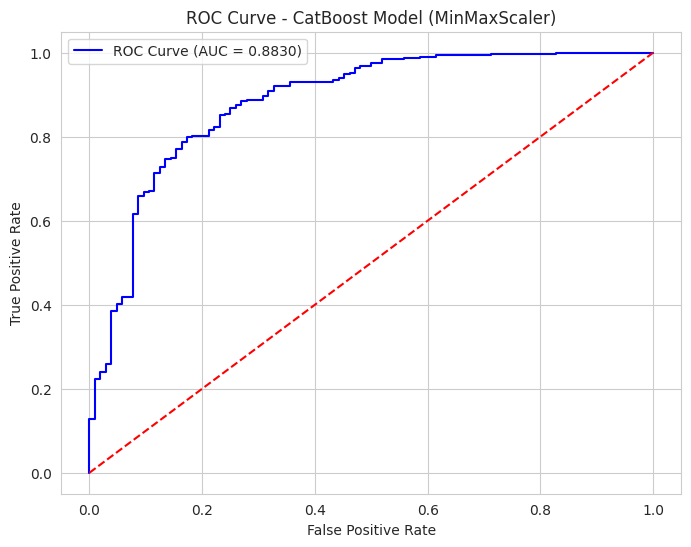

In [132]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# CatBoost 모델 생성 및 학습
cat_model = CatBoostClassifier(**best_cat_params_minmax, verbose=0)  # 최적 파라미터 사용
cat_model.fit(X_train_minmax, y_train_minmax)  # 학습 데이터로 모델 학습

# Validation 데이터에 대한 예측
y_val_pred_proba = cat_model.predict_proba(X_val_minmax)[:, 1]  # 클래스 1의 확률 예측
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)  # 확률을 이진 값으로 변환

# 모델 성능 평가
auc_score = roc_auc_score(y_val_minmax, y_val_pred_proba)
print(f'Validation ROC-AUC Score: {auc_score:.4f}')
print(classification_report(y_val_minmax, y_val_pred))

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_val_minmax, y_val_pred_proba)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color="red", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost Model (MinMaxScaler)")
plt.legend()
plt.show()


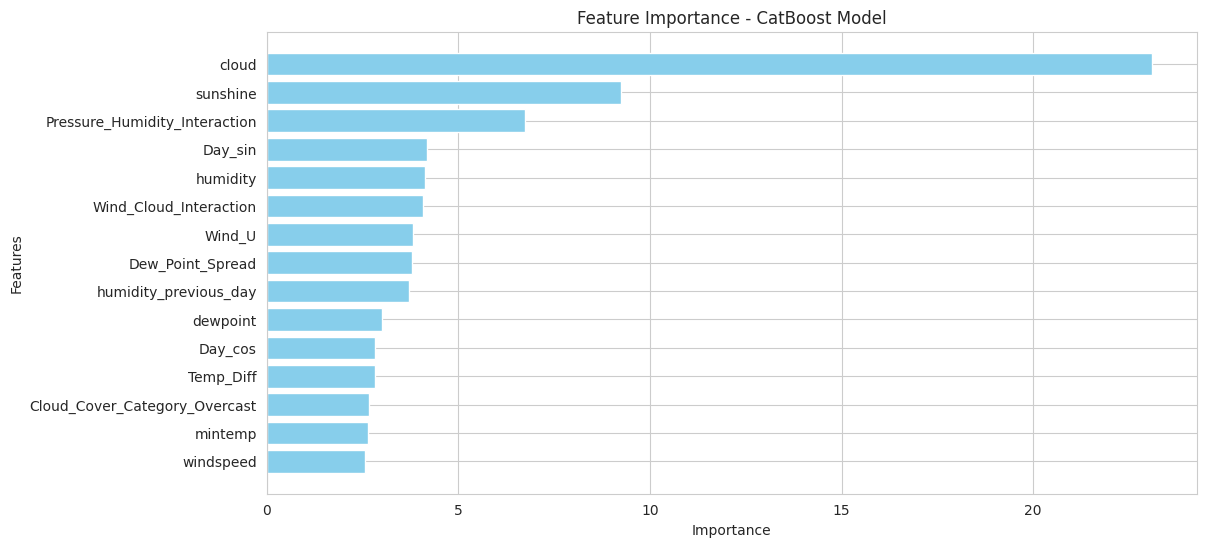

In [133]:
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np

# Feature importance 계산
feature_importances = cat_model.get_feature_importance(Pool(X_train_minmax, y_train_minmax))  # 학습 데이터 사용
feature_names = X_train_minmax.columns  # 특성 이름 (데이터프레임이라면 열 이름 가져옴)

# Feature 중요도를 내림차순으로 정렬
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]
sorted_features = feature_names[sorted_idx]

# 상위 15개 특징만 시각화
top_n = 15
plt.figure(figsize=(12, 6))
plt.barh(sorted_features[:top_n][::-1], sorted_importances[:top_n][::-1], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - CatBoost Model")
plt.show()


In [134]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.feature_names]

# 특성 중요도 그래프에서 중요도가 4 이상인 특성 선택
selected_features = ['cloud', 'sunshine', 'Pressure_Humidity_Interaction', 'Day_sin', 'humidity', 
                     'Wind_Cloud_Interaction', 'Wind_U', 'Dew_Point_Spread', 'humidity_previous_day', 
                     'dewpoint', 'Day_cos', 'Temp_Diff', 'Cloud_Cover_Category_Overcast', 'mintemp', 'windspeed']

# FeatureSelector 객체 생성
features_trans = FeatureSelector(selected_features)

In [135]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 학습 및 테스트 데이터 분리
X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(
    X_train_minmax, y_train_minmax, test_size=0.2, random_state=42
)

# CatBoost, LightGBM, XGBoost 모델 파라미터 (예시)
cat_params = {'iterations': 444, 'learning_rate': 0.02719990455523856, 'depth': 4, 'colsample_bylevel': 0.8281166222118082, 'random_strength': 0.5595440201585744, 'bagging_temperature': 0.15595579496555936, 'l2_leaf_reg': 5.201959735744358}
lgb_params = {'n_estimators': 164, 'learning_rate': 0.035687909929281024, 'max_depth': 3, 'num_leaves': 257, 'feature_fraction': 0.8845102179863847, 'bagging_fraction': 0.9692275033458516, 'bagging_freq': 5, 'min_child_samples': 74}
xgb_params = {'n_estimators': 471, 'learning_rate': 0.011692226575235137, 'max_depth': 4, 'subsample': 0.24703346740902898, 'colsample_bytree': 0.9974564899137633, 'min_child_weight': 3}

# StackingClassifier 생성
estimators = [
    ('cat', make_pipeline(features_trans, CatBoostClassifier(**cat_params, verbose=0))),
    ('lgb', make_pipeline(features_trans, LGBMClassifier(**lgb_params, verbose=-1))),
    ('xgb', make_pipeline(features_trans, XGBClassifier(**xgb_params)))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LGBMClassifier(**lgb_params, verbose=-1),  # 최종 메타 모델
    n_jobs=-1
)

# 모델 학습
stacking_model.fit(X_train_stack, y_train_stack)

# 테스트 데이터로 예측
y_pred_proba = stacking_model.predict_proba(X_test_stack)[:, 1]  # 클래스 1의 확률
y_pred = (y_pred_proba >= 0.5).astype(int)  # 확률을 이진 예측으로 변환

# 모델 평가
auc_score = roc_auc_score(y_test_stack, y_pred_proba)
print(f'Test ROC-AUC Score: {auc_score:.4f}')
print(classification_report(y_test_stack, y_pred))

Test ROC-AUC Score: 0.8941
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        86
           1       0.91      0.90      0.91       260

    accuracy                           0.86       346
   macro avg       0.81      0.82      0.81       346
weighted avg       0.86      0.86      0.86       346



## **Random Forest를 포함한 스태킹**

In [137]:
# Random Forest => optuna를 활용한 하이퍼파라미터 최적화
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

# 학습 및 검증 데이터 설정
X_train, X_valid, y_train, y_valid = X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax

# RandomForest 최적화 함수 정의
def objective_rf(trial):
    # 하이퍼파라미터 범위 설정
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # 트리 개수
        'max_depth': trial.suggest_int('max_depth', 3, 20),  # 트리 깊이
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),  # 노드 분할 기준 샘플 수
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),  # 리프 노드 최소 샘플 수
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),  # 특성 선택 방법
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])  # 부트스트랩 샘플링 여부
    }

    # RandomForest 모델 생성
    model = RandomForestClassifier(**params, random_state=42)
    
    # Cross-validation으로 성능 측정 (ROC-AUC 기준)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(roc_auc_score), n_jobs=-1)
    return scores.mean()

# Optuna 실행
study_rf = optuna.create_study(direction='maximize')  # AUC 최대화
study_rf.optimize(objective_rf, n_trials=50)  # 50번의 최적화 시도

# 최적의 하이퍼파라미터 출력
best_rf_params = study_rf.best_params
print("Best Parameters for RandomForest:", best_rf_params)

# 최적 하이퍼파라미터로 모델 생성 및 학습
rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
rf_model.fit(X_train, y_train)

# 검증 데이터 성능 평가
y_pred_proba = rf_model.predict_proba(X_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_pred_proba)
print(f'Validation ROC-AUC Score: {auc_score:.4f}')


Best Parameters for RandomForest: {'n_estimators': 336, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}
Validation ROC-AUC Score: 0.8643


In [138]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# 학습 및 테스트 데이터 분리
X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(
    X_train_minmax, y_train_minmax, test_size=0.2, random_state=42
)

# RandomForest 최적화된 파라미터
rfc_params = {'n_estimators': 336, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}

# 스태킹에 포함될 개별 모델 정의
estimators = [
    ('rfc', make_pipeline(features_trans, RandomForestClassifier(**rfc_params))),  # 최적 RandomForest
    ('xgb', make_pipeline(features_trans, XGBClassifier(**xgb_params))),  # XGBoost 모델
    ('lgb', make_pipeline(features_trans, LGBMClassifier(**lgb_params, verbose=-1))),  # LightGBM 모델
    ('cat', make_pipeline(features_trans, CatBoostClassifier(**cat_params, verbose=0)))  # CatBoost 모델
]

# StackingClassifier 설정
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LGBMClassifier(**lgb_params, verbose=-1),  # 최종 메타 모델
    n_jobs=-1
)

# 모델 학습
stacking_model.fit(X_train_stack, y_train_stack)

# 테스트 데이터로 예측
y_pred_proba = stacking_model.predict_proba(X_test_stack)[:, 1]  # 클래스 1의 확률
y_pred = (y_pred_proba >= 0.5).astype(int)  # 확률을 이진 예측으로 변환

# 모델 평가
auc_score = roc_auc_score(y_test_stack, y_pred_proba)
print(f'Test ROC-AUC Score: {auc_score:.4f}')
print(classification_report(y_test_stack, y_pred))


Test ROC-AUC Score: 0.8992
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        86
           1       0.91      0.90      0.91       260

    accuracy                           0.86       346
   macro avg       0.81      0.82      0.81       346
weighted avg       0.86      0.86      0.86       346

